In [1]:
#Basic imports
import os
import random
import numpy as np
import copy as cp
import sys
from tqdm import tqdm
import nltk
import math
import spacy

#Dataset imports
from transformers import DataCollatorWithPadding
import pandas as pd 
import datasets
import re
import json
import unicodedata

#Model fine-tuning imports
import torch
from torch.utils.data import DataLoader 
from transformers import AutoModelForSequenceClassification, AutoTokenizer, get_linear_schedule_with_warmup
import time
from timeit import default_timer as timer
import datetime

#Explainer imports
from lime.lime_text import LimeTextExplainer
import lime
import lime.lime_tabular

from captum.attr import visualization

from IPython.display import display, HTML
from matplotlib import pyplot as plt
import matplotlib

#LING imports
from textblob import Blobber
from textblob_fr import PatternTagger, PatternAnalyzer
tb = Blobber(pos_tagger=PatternTagger(), analyzer=PatternAnalyzer())

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

from sklearn.model_selection import learning_curve
from sklearn.svm import SVC
from sklearn.datasets import load_digits

import statsmodels.api as sm

import fr_core_news_sm


from sklearn import preprocessing
from BERT_explainability.modules.BERT.BertForSequenceClassification import CamembertForSequenceClassification
from BERT_explainability.modules.BERT.ExplanationGenerator import Generator
import pickle


print(torch.__version__)

# Your GPU architecture should be listed in the command below.
# If not, download another cuda version or use CPU
print(torch.cuda.get_arch_list())

/DATA3/users/jebogaert/Documents/venvNb/lib/python3.10/site-packages/thinc/compat.py:36: UserWarning: 'has_mps' is deprecated, please use 'torch.backends.mps.is_built()'
  hasattr(torch, "has_mps")
/DATA3/users/jebogaert/Documents/venvNb/lib/python3.10/site-packages/thinc/compat.py:37: UserWarning: 'has_mps' is deprecated, please use 'torch.backends.mps.is_built()'
  and torch.has_mps  # type: ignore[attr-defined]


2.2.2+cu121
['sm_50', 'sm_60', 'sm_70', 'sm_75', 'sm_80', 'sm_86', 'sm_90']


In [2]:
def seed_worker(worker_id):
    worker_seed = seed
    numpy.random.seed(worker_seed)
    random.seed(worker_seed)
    
def set_seed(seed):
    """Set all seeds to make results reproducible (deterministic mode).
       When seed is None, disables deterministic mode.
    :param seed: an integer to your choosing
    """
    if seed is not None:
        torch.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False
        np.random.seed(seed)
        random.seed(seed)
        os.environ['PYTHONHASHSEED'] = str(seed)
        os.environ["CUBLAS_WORKSPACE_CONFIG"] = ":16:8"
        
seed = 0
set_seed(seed)
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

# Bert Explanations

In [3]:
import subprocess as sp
import os

def get_gpu_memory():
    command = "nvidia-smi --query-gpu=memory.free --format=csv"
    memory_free_info = sp.check_output(command.split()).decode('ascii').split('\n')[:-1][1:]
    memory_free_values = [int(x.split()[0]) for i, x in enumerate(memory_free_info)]
    return memory_free_values

# Frozen models

In [4]:
model = AutoModelForSequenceClassification.from_pretrained('camembert-base')
model.to(device)

tokenizer = AutoTokenizer.from_pretrained('camembert-base', do_lowercase=True)

Some weights of CamembertForSequenceClassification were not initialized from the model checkpoint at camembert-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [5]:
from Code.data_processing import preprocess, tokenize, create_dataset, get_text_tokens
from Code.model_explainer import get_model, save_model
from transformers import DataCollatorWithPadding
from torch.utils.data import DataLoader 
from transformers.utils import logging
import pandas as pd 
import datasets
    
def build_set(tokenizer, batch_size=4):
    
    logging.set_verbosity_error()

    model = AutoModelForSequenceClassification.from_pretrained('camembert-base', output_loading_info=False)
    tokenizer = AutoTokenizer.from_pretrained('camembert-base', do_lowercase=True)

    dataDfInit = pd.read_csv("NeededFiles/dataset/rtbf_dataset_10000_pp_11may23.csv", sep='|')

    dataDfInit = dataDfInit.rename(columns={"text_clean": "text"})
    dataDfInit['label'] = dataDfInit.apply(lambda a: int(a['label'] == 'chron'), axis=1)
    dataDfInit["text"] = dataDfInit["text"].apply(lambda a : preprocess(a, full=True))
    dataDfInit["text"] = dataDfInit["text"].apply(lambda a : get_text_tokens(a,  tokenizer))

    train_df, val_df, test_df = create_dataset(dataDfInit, seed = 42)
    
    train_df = train_df[['text', 'label']]
    val_df = val_df[['text', 'label']]
    test_df = test_df[['text', 'label']]

    train_ds = datasets.Dataset.from_pandas(train_df.sample(frac=1, random_state = seed))
    val_ds = datasets.Dataset.from_pandas(val_df.sample(frac=1, random_state = seed))
    test_ds = datasets.Dataset.from_pandas(test_df.sample(frac=1, random_state = seed))

    dataset = datasets.DatasetDict({"train":train_ds,"val":val_ds, "test": test_ds})
    tokenized_dataset_full = dataset.map(lambda a: tokenize(a["text"], tokenizer, shorten=True), batched=True)
    
    train_text, Y_train = tokenized_dataset_full["train"]["text"], tokenized_dataset_full["train"]["label"]
    val_text, Y_val = tokenized_dataset_full["val"]["text"], tokenized_dataset_full["val"]["label"]
    test_text, Y_test = tokenized_dataset_full["test"]["text"], tokenized_dataset_full["test"]["label"]

    train_st = tokenized_dataset_full["train"]['special_tokens']
    val_st = tokenized_dataset_full["val"]['special_tokens']
    test_st = tokenized_dataset_full["test"]['special_tokens']

    tokenized_dataset = tokenized_dataset_full.remove_columns(['text', 'special_tokens'])
    data_collator = DataCollatorWithPadding(tokenizer=tokenizer, max_length = 512, padding = 'max_length')

    g_train = torch.Generator()
    g_train.manual_seed(seed)

    g_val = torch.Generator()
    g_val.manual_seed(seed)

    g_test = torch.Generator()
    g_test.manual_seed(seed)
    
    train = DataLoader(tokenized_dataset["train"], 
                       shuffle=False,
                       batch_size=batch_size,
                       collate_fn=data_collator,
                       generator=g_train)

    val = DataLoader(tokenized_dataset["val"], 
                       shuffle=False,
                       batch_size=batch_size,
                       collate_fn=data_collator,
                       generator=g_val)

    test = DataLoader(tokenized_dataset["test"], 
                       shuffle=False,
                       batch_size=batch_size,
                       collate_fn=data_collator,
                       generator=g_val)
        
    return (train, val, test), (train_text, val_text, test_text), (train_st, val_st, test_st)

batch_size=4
sets, texts, special_tokens = build_set(tokenizer, batch_size=batch_size)
train, val, test = sets[0], sets[1], sets[2]
train_text, val_text, test_text = texts[0], texts[1], texts[2]
train_st, val_st, test_st = special_tokens[0], special_tokens[1], special_tokens[2]

  0%|          | 0/8 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

In [6]:
heap = test_text
heap.sort(key=lambda a: len(a.split()))
test_text_expl = heap[:10] + heap[-10:]
print(len(test_text_expl))
print(test_text_expl[0])
print(test_text_expl)

20
Le procès d' assises qui s' est ouvert lundi NBR mai reprendra donc ce jeudi NBR mai après quelques jours d' interruption .
["Le procès d' assises qui s' est ouvert lundi NBR mai reprendra donc ce jeudi NBR mai après quelques jours d' interruption .", "Dans l' électroménager , les appareils encastrables sont assez chers . Est-ce ou non justifié ? Paul-Henri Burrion et Caroline Veyt nous en parlent .", 'Une sélection proposée par ordre de passage dans l\' émission " Entrez sans frapper " , le vendredi à NBR h NBR . Une chronique de Laurent Dehossay . Le Prix Première sera décerné à la Foire du Livre de Bruxelles , le NBR février .', "C' est finalement le GRIMP , le service spécialisé dans les sauvetages en milieu périlleux , qui a réussi à remonter les deux jeunes , à l' aide de cordes et de civières de montagne . Légèrement blessés , ils ont été transportés à l' hôpital .", "Les policiers ont chargé des petits groupes de manifestants et les ont battus avec des bâtons pour les disper

In [25]:
# inspired from https://gist.github.com/AyushExel/8b64663ec2022cf74a2bc8ca70f33f64

import time 
import copy as cp
from torch.nn import Softmax
#from tqdm.notebook import tqdm
import datetime


def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))


def train_model(model, train_set, val, device, epochs=2, inplace=False):
    
    if not inplace:
        model = cp.deepcopy(model)
    
    optimizer = torch.optim.AdamW(model.parameters(),
                  lr = 2e-5, 
                  eps = 1e-8
                )

    batches_per_epoch = len(train_set) // batch_size

    total_steps = int(batches_per_epoch * epochs)

    scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)

    
    training_stats = []

    total_t0 = time.time()
    model.train()
    
    for epoch_i in range(0, epochs):

        # ========================================
        #               Training
        # ========================================

        print("")
        print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
        print('Training...')

        t0 = time.time()

        total_train_loss = 0
        all_input_ids = []
        for step, batch in enumerate(tqdm(train_set, total=len(train_set))):

            model.zero_grad()
            optimizer.zero_grad()
            
            cp_batch = cp.deepcopy(batch)
            b_input_ids = cp_batch['input_ids'].to(device)
            all_input_ids.append(b_input_ids.detach().cpu())
            b_input_mask = cp_batch['attention_mask'].to(device)
            b_labels = cp_batch['labels'].to(device)        

            loss, logits = model(b_input_ids, 
                                 token_type_ids=None, 
                                 attention_mask=b_input_mask, 
                                 labels=b_labels)[:2]

            total_train_loss += loss.item()

            loss.backward()

            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

            optimizer.step()

            scheduler.step()

        avg_train_loss = total_train_loss / len(train_set)            

        training_time = format_time(time.time() - t0)

        print("")
        print("  Average training loss: {0:.2f}".format(avg_train_loss))
        print("  Training epcoh took: {:}".format(training_time))

        # ========================================
        #               Validation
        # ========================================

        print("")
        print("Running Validation...")

        t0 = time.time()

        model.eval()

        total_eval_accuracy = 0
        total_eval_loss = 0
        nb_eval_steps = 0

        for step, batch in enumerate(tqdm(val, total=len(val))):

            cp_batch = cp.deepcopy(batch)
            b_input_ids = cp_batch['input_ids'].to(device)
            b_input_mask = cp_batch['attention_mask'].to(device)
            b_labels = cp_batch['labels'].to(device)

            with torch.no_grad():        

                loss, logits = model(b_input_ids, 
                                        token_type_ids=None, 
                                        attention_mask=b_input_mask,
                                        labels=b_labels)[:2]

            total_eval_loss += loss.item()

            logits = logits.detach().cpu().numpy()
            label_ids = b_labels.to('cpu').numpy()

            total_eval_accuracy += flat_accuracy(logits, label_ids)


        avg_val_accuracy = total_eval_accuracy / len(val)
        print("  Accuracy: {0:.4f}".format(avg_val_accuracy))

        avg_val_loss = total_eval_loss / len(val)

        validation_time = format_time(time.time() - t0)

        print("  Validation Loss: {0:.4f}".format(avg_val_loss))
        print("  Validation took: {:}".format(validation_time))

        training_stats.append(
            {
                'epoch': epoch_i + 1,
                'Training Loss': avg_train_loss,
                'Valid. Loss': avg_val_loss,
                'Valid. Accur.': avg_val_accuracy,
                'Training Time': training_time,
                'Validation Time': validation_time
            }
        )

    print("")
    print("Training complete!")

    print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))
    
    return model, all_input_ids

def test_model(model, test, device, get_preds = False, with_grad = True, get_acc=True):
    print("")
    print("Running Test...")
    t0 = time.time()
    total_eval_accuracy = 0

    model.eval()

    predictions, true_labels = [], []

    for step, batch in enumerate(tqdm(test, total = len(test))):

        cp_batch = cp.deepcopy(batch)
        b_input_ids = cp_batch['input_ids'].to(device)
        b_input_mask = cp_batch['attention_mask'].to(device)
        b_labels = cp_batch['labels'].to(device)
        if with_grad:
            loss, logits = model(b_input_ids, token_type_ids=None, 
                              attention_mask=b_input_mask)[:2]
            model.zero_grad()
        else:
            with torch.no_grad():        
                logits = model(b_input_ids, token_type_ids=None, 
                              attention_mask=b_input_mask)[0]

        if get_preds:
            soft = Softmax()
            preds = soft(logits).detach().cpu().numpy()
            predictions += list(np.argmax(preds, axis=1))
        
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.cpu().numpy()

        total_eval_accuracy += flat_accuracy(logits, label_ids)
        
        true_labels.append(label_ids)


    avg_test_accuracy = total_eval_accuracy / len(test)
    print("  Accuracy: {0:.4f}".format(avg_test_accuracy))
    
    if get_preds:
        return predictions
    if get_acc:
        return "  Accuracy: {0:.4f}".format(avg_test_accuracy)

In [8]:
from Code.model_explainer import extract_embeddings
from sklearn.utils import shuffle

frozen_train_emb, labels_train, _ = extract_embeddings(train, model, layers = [12])
frozen_val_emb, labels_val, _ = extract_embeddings(val, model, layers = [12])
frozen_test_emb, labels_test, _ = extract_embeddings(test, model, layers = [12])

train_init, labels_train_init = shuffle(frozen_train_emb[12], labels_train, random_state=0)
val_init, labels_val_init = shuffle(frozen_val_emb[12], labels_val, random_state=0)
test_init, labels_test_init = shuffle(frozen_test_emb[12], labels_test, random_state=0)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 250/250 [00:09<00:00, 27.48it/s]


In [9]:
#For frozen expl
from BERT_explainability.modules.layers_ours import Linear
from torch.nn.parameter import Parameter
from sklearn.metrics import accuracy_score

from torch import nn
from BERT_explainability.modules.layers_ours import Dropout, Linear, Tanh

class RobertaClassificationHead(nn.Module):
    """Head for sentence-level classification tasks."""

    def __init__(self, config):
        super().__init__()
        classifier_dropout = (
            config.classifier_dropout if config.classifier_dropout is not None else config.hidden_dropout_prob
        )
        self.dropout1 = Dropout(classifier_dropout)
        self.dense = Linear(config.hidden_size, config.hidden_size)
        self.tanh = Tanh()
        self.dropout2 = Dropout(classifier_dropout)
        self.out_proj = Linear(config.hidden_size, config.num_labels)

    def forward(self, features, **kwargs):
        try:
            x = features[:, 0, :] # take <s> token (equiv. to [CLS])
        except:
            x = features 
        x = self.dropout1(x)
        x = self.dense(x)
        x = self.tanh(x)
        x = self.dropout2(x)
        x = self.out_proj(x)
        return x

    def relprop(self, cam, **kwargs):
        cam = self.out_proj.relprop(cam, **kwargs)
        cam = self.dropout2.relprop(cam, **kwargs)
        cam = self.tanh.relprop(cam, **kwargs)
        cam = self.dense.relprop(cam, **kwargs)
        cam = self.dropout1.relprop(cam, **kwargs)
        return cam

def flat_accuracy(logits, labels):
    return np.mean([int(np.argmax(logit) == label) for logit, label in zip(logits, labels)])

In [10]:
from transformers.modeling_outputs import SequenceClassifierOutput
from transformers import get_linear_schedule_with_warmup
import random
import numpy as np 
import time
import copy as cp
from torch.nn import CrossEntropyLoss
#from tqdm.notebook import tqdm


def train_frozen_model(model, train, val, labels_train, labels_val):
    
    rFrozen = cp.deepcopy(model)
    total_train_loss = 0
    batch_size =  4
    epochs = 4
    optimizer = torch.optim.AdamW(rFrozen.parameters(),
                      lr =  1e-3, 
                      eps = 1e-8
                )

    batches_per_epoch = len(labels_train) // batch_size

    total_steps = int(batches_per_epoch * epochs)

    scheduler = get_linear_schedule_with_warmup(optimizer, 
                                                num_warmup_steps = 0, # Default value in run_glue.py
                                                num_training_steps = total_steps)

    training_stats = []

    total_t0 = time.time()
    for epoch_i in range(0, epochs):

        t0 = time.time()

        total_train_loss = 0

        rFrozen.train()

        input_ids, labels = [], []
        for step, batch in enumerate(zip(train, labels_train)):
            cp_batch = cp.deepcopy(batch)
            input_ids += [cp_batch[0]]
            labels += [cp_batch[1]]

            if step%batch_size != batch_size-1 and step!=len(labels_train)-1:
                continue

            b_input_ids = torch.tensor(input_ids).to(device)
            b_labels = torch.tensor(labels).to(device)
            input_ids, labels = [], []

            rFrozen.zero_grad()        

            logits = rFrozen(b_input_ids,  
                            labels=b_labels)

            loss= CrossEntropyLoss().forward(logits.view(-1, 2), b_labels.view(-1))

            total_train_loss += loss.item()*batch_size

            loss.backward()

            torch.nn.utils.clip_grad_norm_(rFrozen.parameters(), 1.0)
            optimizer.step()
            scheduler.step()

        avg_train_loss = total_train_loss / len(labels_train)            


        t0 = time.time()

        rFrozen.eval()

        total_eval_accuracy = 0
        total_eval_loss = 0
        nb_eval_steps = 0
        labels, input_ids = [], []

        for step, batch in enumerate(zip(val, labels_val)):

            cp_batch = cp.deepcopy(batch)

            input_ids += [cp_batch[0]]
            labels += [cp_batch[1]]

            if step%batch_size != batch_size-1 and step!=len(labels_val)-1:
                continue

            b_input_ids = torch.tensor(input_ids).to(device)
            b_labels = torch.tensor(labels).to(device)
            input_ids, labels = [], []

            with torch.no_grad():        

                logits = rFrozen(b_input_ids,  
                            labels=b_labels)

            loss= CrossEntropyLoss().forward(logits.view(-1, 2), b_labels.view(-1))
            total_eval_loss += loss.item()

            logits = logits.detach().cpu().numpy()
            label_ids = b_labels.to('cpu').numpy()
            total_eval_accuracy += flat_accuracy(logits, label_ids)


        avg_val_accuracy = total_eval_accuracy / (len(labels_val)/batch_size)
        avg_val_loss = total_eval_loss / (len(labels_val)/batch_size)
        print("  Accuracy: {0:.4f}".format(avg_val_accuracy), "  Validation Loss: {0:.4f}".format(avg_val_loss))
        
    return rFrozen

def test_frozen_model(rFrozen, test, labels_test, get_preds = False):
    
    rFrozen.eval()
    
    total_eval_accuracy = 0
    total_eval_loss = 0
    batch_size = 1
    
    predictions = []
    
    labels, input_ids = [], []
    for step, batch in enumerate(zip(test, labels_test)):

        cp_batch = cp.deepcopy(batch)

        input_ids += [cp_batch[0]]
        labels += [cp_batch[1]]

        if step%batch_size != batch_size-1 and step!=len(labels_test)-1:
            continue
            
        b_input_ids = torch.tensor(input_ids).to(device)
        b_labels = torch.tensor(labels).to(device)
        input_ids, labels = [], []

        with torch.no_grad():        

            logits = rFrozen(b_input_ids,  
                            labels=b_labels)
    
        loss= CrossEntropyLoss().forward(logits.view(-1, 2), b_labels.view(-1))

        total_eval_loss += loss.item()

        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
        total_eval_accuracy += flat_accuracy(logits, label_ids)
        
        predictions += [i for i in np.argmax(logits, axis=1)] 

    avg_test_accuracy = total_eval_accuracy /(len(labels_test)/batch_size)
    avg_test_loss = total_eval_loss /(len(labels_test)/batch_size)
    print("  Accuracy: {0:.4f}".format(avg_test_accuracy), "  Test Loss: {0:.4f}".format(avg_test_loss))   
    
    if get_preds:
        return avg_test_accuracy, predictions

    return avg_test_accuracy

In [11]:
import argparse
import numpy as np
import torch
import glob
from torch import autocast


def compute_rollout_attention(all_layer_matrices, start_layer=0):
    # adding residual consideration- code adapted from https://github.com/samiraabnar/attention_flow
    num_tokens = all_layer_matrices[0].shape[1]
    batch_size = all_layer_matrices[0].shape[0]
    eye = torch.eye(num_tokens).expand(batch_size, num_tokens, num_tokens).to(all_layer_matrices[0].device)
    all_layer_matrices = [all_layer_matrices[i] + eye for i in range(len(all_layer_matrices))]
    matrices_aug = [all_layer_matrices[i] / all_layer_matrices[i].sum(dim=-1, keepdim=True)
                          for i in range(len(all_layer_matrices))]
    joint_attention = matrices_aug[start_layer]
    for i in range(start_layer+1, len(matrices_aug)):
        joint_attention = matrices_aug[i].bmm(joint_attention)
    return joint_attention


class Generator:
    def __init__(self, model):
        self.model = model
        self.model.eval()

    def forward(self, input_ids, attention_mask):
        return self.model(input_ids, attention_mask)

    def generate_LRP(self, input_ids, attention_mask,
                     index=None, start_layer=11):
        
        with autocast(device_type='cuda', dtype=torch.float32):
            output = self.model(input_ids=input_ids, attention_mask=attention_mask)[1].to(input_ids.device)
            kwargs = {"alpha": 1}
        
            if index is None:
                index = np.argmax(output.cpu().data.numpy(), axis=-1)

        
            one_hot = np.zeros((1, output.size()[-1]), dtype=np.float32)
            one_hot[0, index] = 1
            one_hot_vector = one_hot
            one_hot = torch.from_numpy(one_hot).requires_grad_(True).to(input_ids.device)
            one_hot = torch.sum(one_hot * output)

            self.model.zero_grad()
            one_hot.backward(retain_graph=True)


            one_hot_vector_t = torch.tensor(one_hot_vector).to(input_ids.device)
            cam = self.model.relprop(one_hot_vector_t, **kwargs)
            one_hot_vector_t = one_hot_vector_t.detach()

            cams = []
            if hasattr(self.model, "roberta"):
                blocks = self.model.roberta.encoder.layer
                for blk in blocks:
                    grad = blk.attention.self.get_attn_gradients()
                    cam = blk.attention.self.get_attn_cam()
                    cam = cam[0].reshape(-1, cam.shape[-1], cam.shape[-1])
                    grad = grad[0].reshape(-1, grad.shape[-1], grad.shape[-1])
                    cam = grad * cam
                    cam = cam.clamp(min=0).mean(dim=0)
                    cams.append(cam.unsqueeze(0))

                rollout = compute_rollout_attention(cams, start_layer=start_layer)
                rollout[:, 0, 0] = rollout[:, 0].min()    
                return rollout[:, 0]
            else:
                return cam

In [12]:
from Code.data_processing import convert_to_tok, retokenize, get_text_tokens

def explain_camembert(texts, tokenizer, model, explainer, device=torch.device("cpu")):
    text_batch = texts
    expls_bert = []
    y_pred_bert = []
    classifications = ["information", "opinion"]
    
    for nbr, itm in enumerate(tqdm(text_batch, total = len(text_batch))):  
        itm = get_text_tokens(itm, tokenizer, shorten=True)
        
        encoding = tokenize([itm], tokenizer)
        special_tokens = encoding['special_tokens']
        input_ids = torch.tensor(encoding['input_ids']).to(device)
        attention_mask = torch.tensor(encoding['attention_mask']).to(device)
        
        expl = explainer.generate_LRP(input_ids=input_ids, attention_mask=attention_mask, start_layer=1)[0]
        # normalize scores
        expl = expl.detach()
        
        
        expl = (expl - expl.min()) / (expl.max() - expl.min())
        # get the model classification
        output = torch.nn.functional.softmax(model(input_ids=input_ids, attention_mask=attention_mask)[1], dim=-1).to("cpu")
        
        
        classification = output.argmax(dim=-1).item()
        y_pred_bert += [classification]
        
        # get class name
        class_name = classifications[classification]
        
        # if the classification is negative, higher explanation scores are more negative
        # flip for visualization
        if class_name == "opinion":
            expl *= (-1)
        
        tokens = convert_to_tok(input_ids.detach().to("cpu").flatten(), tokenizer, special_tokens=special_tokens[0])
        tokensFinal, expli = retokenize(tokens, expl)
        
        expli = [i.detach() for i in expli]

        expls_bert.append([(i[0].item(), i[1]) for i in zip(expli, itm.split())])
        
        input_ids.to("cpu")
        attention_mask.to("cpu")
        del encoding
        del input_ids
        del attention_mask
        del expl
        del output
        del tokens
        del tokensFinal
        del expli
    del model
    del tokenizer
    del explainer
    return expls_bert

In [13]:
import gc
def explain_for_seed(seed, expl_device = torch.device("cpu")):
    set_seed(seed)
    rFrozen = RobertaClassificationHead(model.config)
    rFrozen.to(device)
    
    train_cp, labels_train_cp = cp.deepcopy(train_init), cp.deepcopy(labels_train_init)
    val_cp, labels_val_cp = cp.deepcopy(val_init), cp.deepcopy(labels_val_init)
    test_cp, labels_test_cp = cp.deepcopy(test_init), cp.deepcopy(labels_test_init)
    
    train, labels_train = shuffle(train_cp, labels_train_cp, random_state=seed)
    val, labels_val = shuffle(val_cp, labels_val_cp, random_state=seed)
    test, labels_test = shuffle(test_cp, labels_test_cp, random_state=seed)
    
    trained_model_frozen = train_frozen_model(rFrozen, train, val, labels_train, labels_val)
    test_acc = test_frozen_model(trained_model_frozen, test, labels_test)

    frozen_model = cp.deepcopy(model)
    frozen_model.classifier = trained_model_frozen
    frozen_model.to(device)
    frozen_model.eval()

    save_model(frozen_model, tokenizer, f'NeededFiles/models/frozen/{seed}')
    
    model_expl_fro = CamembertForSequenceClassification.from_pretrained(f'NeededFiles/models/frozen/{seed}')
    model_expl_fro.eval()
    
    explainer_fro = Generator(model_expl_fro)
    
    tokenizer_expl_fro = AutoTokenizer.from_pretrained(f'NeededFiles/models/frozen/{seed}')

    model_expl_fro.to(expl_device)
     
    dict_explanations_fro = explain_camembert(test_text_expl, tokenizer_expl_fro, model_expl_fro, explainer_fro, device=expl_device)
    with open(f'NeededFiles/explanations/explanations_frozen.pickle', 'ab+') as f:
        pickle.dump(dict_explanations_fro, f)

    with open(f'NeededFiles/accuracies_frozen', 'a+') as f:
        f.write(f'{test_acc}\n')
    
    model_expl_fro.to("cpu")
    
    gc.collect()
    torch.cuda.empty_cache()
        
    del rFrozen 
    del train_cp
    del val_cp
    del test_cp
    del train
    del val
    del test
    del trained_model_frozen
    del frozen_model
    del model_expl_fro
    del explainer_fro
    del tokenizer_expl_fro
    del dict_explanations_fro    

In [14]:
recompute_expls = False
if recompute_expls:
    import pickle
    from tqdm import tqdm
    from Code.model_explainer import save_model
    import torch
    import gc

    start_memory = get_gpu_memory()[0]
    configFro = model.config
    configFro.classifier_dropout=0 #delete the dropout for the frozen model as it reaches better results without
    expl_device = torch.device("cpu")
    for seed in range(134, 200):
        print(f"RUNNING SEED {seed}")
        current_memory = get_gpu_memory()[0]
        print(f"Current memory use = {current_memory}")
        explain_for_seed(seed, expl_device)

In [5]:
import pickle
count = 0
all_expls = []
with open(f'NeededFiles/explanations/explanations_frozen.pickle', 'rb') as f:
    while True:
        try:
            dict_explanations_fro = pickle.load(f)
            all_expls+=[dict_explanations_fro]
            count+=1
        except:
            print(count)
            break


accuracies = []
with open(f'NeededFiles/accuracies_frozen', 'r') as f:
    for line in f:
        accuracies += [float(line.replace("\n", ""))]

200


In [19]:
from transformers import BitsAndBytesConfig
import bitsandbytes
quantization_config_fp4 = BitsAndBytesConfig(
                            load_in_4bit=True,
                            bnb_4bit_use_double_quant=True,
                            bnb_4bit_quant_type="fp4",
                            bnb_4bit_compute_dtype=torch.float32
                            )

quantization_config_nf4 = BitsAndBytesConfig(
                            load_in_4bit=True,
                            bnb_4bit_use_double_quant=True,
                            bnb_4bit_quant_type="nf4",
                            bnb_4bit_compute_dtype=torch.float32,
                            )

In [20]:
import bitsandbytes as bnb
import BERT_explainability.modules.layers_ours as expl_layers
import torch.nn.functional as F
from torch import isnan


def safe_divide(a, b):
    
    den = b.clamp(min=1e-9) + b.clamp(max=1e-9)
    den = den + den.eq(0).type(den.type()) * 1e-9
    return a / den * b.ne(0).type(b.type())

class Linear4bit(bnb.nn.Linear4bit, expl_layers.RelProp):
    def relprop(self, R, alpha):
        beta = alpha - 1
        assert not isnan(R).any()
        assert not isnan(self.weight).any()
        dequant_w = bnb.functional.dequantize_4bit(self.weight, self.weight.quant_state)
        #This is actually quantized in uint8 and not 4 :D
        pw = torch.clamp(dequant_w, min=0)
        nw = torch.clamp(dequant_w, max=0)
        assert not isnan(pw).any()
        assert not isnan(nw).any()
        
        px = torch.clamp(self.X, min=0)
        nx = torch.clamp(self.X, max=0)
        
        assert not isnan(px).any()
        assert not isnan(nx).any()

        def f(w1, w2, x1, x2):
            Z1 = F.linear(x1, w1)
            Z2 = F.linear(x2, w2)
            assert not isnan(Z1).any()
            assert not isnan(Z2).any()
            S1 = safe_divide(R, Z1 + Z2)
            S2 = safe_divide(R, Z1 + Z2)
            assert not isnan(S1).any()
            assert not isnan(S2).any()
            C1 = x1 * self.gradprop(Z1, x1, S1)[0]
            C2 = x2 * self.gradprop(Z2, x2, S2)[0]
            assert not isnan(C1).any()
            assert not isnan(C2).any()

            return C1 + C2

        activator_relevances = f(pw, nw, px, nx)  
        inhibitor_relevances = f(nw, pw, px, nx)

        R = alpha * activator_relevances - beta * inhibitor_relevances
        assert not isnan(R).any()
        return R

In [21]:
#from BERT_explainability.modules.layers_ours import Linear4bit as ExplLin4Bit

def replace_layers(model, old, new):
    for n, module in model.named_children():
        if len(list(module.children())) > 0 and len(old)>0 and n==old[0]:
            replace_layers(module, old[1:], new)
            
        elif len(old)>0 and n==old[0]:
            setattr(model, n, new)

def make_quantized_explainable(model):
    replacement_list = []

    for name, layer in model.named_modules():
        if type(layer) == bitsandbytes.nn.modules.Linear4bit:
            new_lin = Linear4bit(layer.in_features, layer.out_features, True)
            new_lin.weight = layer.weight

            new_lin.bias = layer.bias
            replacement_list += [(name, new_lin)]
            
    for layer_name, new_layer in replacement_list:
        replace_layers(model, layer_name.split('.'), new_layer)

In [22]:
def explain_model(model, tokenizer):
    explaner = Generator(model)
    dict_explanations = explain_camembert(test_text_expl, tokenizer, model, explaner, device=device)
    model.zero_grad()
    return dict_explanations

In [23]:
x=[]
for seed in x:
    current_memory = get_gpu_memory()[0]
    print(f"Current memory use = {current_memory}")
    model_ft_nf4 = CamembertForSequenceClassification.from_pretrained(
        f'../NeededFiles/models/camembert_ft_seed_{seed}',
        quantization_config = quantization_config_nf4,
        device_map={"":0}
    )

    model_ft_fp4 = CamembertForSequenceClassification.from_pretrained(
        f'../NeededFiles/models/camembert_ft_seed_{seed}',
        quantization_config = quantization_config_fp4,
        device_map={"":0}
    )

    model_fro_nf4 = CamembertForSequenceClassification.from_pretrained(
        f'./NeededFiles/models/frozen/{seed}',
        quantization_config = quantization_config_nf4,
        device_map={"":0}
    )

    model_fro_fp4 = CamembertForSequenceClassification.from_pretrained(
        f'./NeededFiles/models/frozen/{seed}',
        quantization_config = quantization_config_fp4,
        device_map={"":0}
    )

    model_ft_nf4.eval()
    model_ft_fp4.eval()
    model_fro_nf4.eval()
    model_fro_fp4.eval()

    tokenizer_ft = AutoTokenizer.from_pretrained(f'../NeededFiles/models/camembert_ft_seed_{seed}')
    tokenizer_fro = AutoTokenizer.from_pretrained(f'./NeededFiles/models/frozen/{seed}')
    
        
    make_quantized_explainable(model_ft_nf4)
    make_quantized_explainable(model_ft_fp4)
    make_quantized_explainable(model_fro_nf4)
    make_quantized_explainable(model_fro_fp4)

    dict_expl_ft_fp4 = explain_model(model_ft_fp4, tokenizer_ft)
    dict_expl_ft_nf4 = explain_model(model_ft_nf4, tokenizer_ft)
    dict_expl_fro_fp4 = explain_model(model_fro_fp4, tokenizer_fro)
    dict_expl_fro_nf4 = explain_model(model_fro_nf4, tokenizer_fro)
    
    with open(f'NeededFiles/explanations/explanations_quantized_ft_fp4.pickle', 'ab+') as f:
        pickle.dump(dict_expl_ft_fp4, f)
        
    with open(f'NeededFiles/explanations/explanations_quantized_ft_nf4.pickle', 'ab+') as f:
        pickle.dump(dict_expl_ft_nf4, f)
    
    with open(f'NeededFiles/explanations/explanations_quantized_fro_fp4.pickle', 'ab+') as f:
        pickle.dump(dict_expl_fro_fp4, f)
        
    with open(f'NeededFiles/explanations/explanations_quantized_fro_nf4.pickle', 'ab+') as f:
        pickle.dump(dict_expl_fro_nf4, f)
    
    
    del model_ft_nf4
    del model_ft_fp4
    del model_fro_nf4
    del model_fro_fp4
current_memory = get_gpu_memory()[0]
print(f"Current memory use = {current_memory}")

Current memory use = 46908


In [ ]:
for seed in range(200):
    current_memory = get_gpu_memory()[0]
    print(f"Current memory use = {current_memory}")
    model_ft_nf4 = AutoModelForSequenceClassification.from_pretrained(
        f'../NeededFiles/models/camembert_ft_seed_{seed}',
        quantization_config = quantization_config_nf4,
        device_map={"":0}
    )

    model_ft_fp4 = AutoModelForSequenceClassification.from_pretrained(
        f'../NeededFiles/models/camembert_ft_seed_{seed}',
        quantization_config = quantization_config_fp4,
        device_map={"":0}
    )

    model_fro_nf4 = AutoModelForSequenceClassification.from_pretrained(
        f'./NeededFiles/models/frozen/{seed}',
        quantization_config = quantization_config_nf4,
        device_map={"":0}
    )

    model_fro_fp4 = AutoModelForSequenceClassification.from_pretrained(
        f'./NeededFiles/models/frozen/{seed}',
        quantization_config = quantization_config_fp4,
        device_map={"":0}
    )

    model_ft_nf4.eval()
    model_ft_fp4.eval()
    model_fro_nf4.eval()
    model_fro_fp4.eval()

    tokenizer_ft = AutoTokenizer.from_pretrained(f'../NeededFiles/models/camembert_ft_seed_{seed}')
    tokenizer_fro = AutoTokenizer.from_pretrained(f'./NeededFiles/models/frozen/{seed}')
    
    
    acc_ft_nf4 = test_model(model_ft_nf4, test, device, with_grad = False, get_acc = True)
    acc_ft_fp4 = test_model(model_ft_fp4, test, device, with_grad = False, get_acc = True)
    acc_fro_nf4 = test_model(model_fro_nf4, test, device, with_grad = False, get_acc = True)
    acc_fro_fp4 = test_model(model_fro_fp4, test, device, with_grad = False, get_acc = True)
    with open("NeededFiles/accuraciesQuantized",'a+') as f:
        f.write(f'{acc_ft_nf4} {acc_ft_fp4} {acc_fro_nf4} {acc_fro_fp4}\n')
    
    
    del model_ft_nf4
    del model_ft_fp4
    del model_fro_nf4
    del model_fro_fp4
current_memory = get_gpu_memory()[0]
print(f"Current memory use = {current_memory}")

Current memory use = 46768

Running Test...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 250/250 [00:08<00:00, 29.44it/s]


  Accuracy: 0.9680

Running Test...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 250/250 [00:08<00:00, 29.36it/s]


  Accuracy: 0.9530

Running Test...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 250/250 [00:08<00:00, 29.06it/s]


  Accuracy: 0.9450

Running Test...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 250/250 [00:08<00:00, 29.04it/s]


  Accuracy: 0.9440
Current memory use = 46576

Running Test...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 250/250 [00:08<00:00, 28.67it/s]


  Accuracy: 0.9570

Running Test...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 250/250 [00:08<00:00, 28.83it/s]


  Accuracy: 0.9520

Running Test...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 250/250 [00:08<00:00, 28.66it/s]


  Accuracy: 0.9480

Running Test...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 250/250 [00:08<00:00, 28.74it/s]


  Accuracy: 0.9480
Current memory use = 46660

Running Test...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 250/250 [00:08<00:00, 28.70it/s]


  Accuracy: 0.9660

Running Test...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 250/250 [00:08<00:00, 28.77it/s]


  Accuracy: 0.9610

Running Test...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 250/250 [00:08<00:00, 28.58it/s]


  Accuracy: 0.9440

Running Test...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 250/250 [00:08<00:00, 28.69it/s]


  Accuracy: 0.9450
Current memory use = 46660

Running Test...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 250/250 [00:08<00:00, 28.50it/s]


  Accuracy: 0.9650

Running Test...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 250/250 [00:08<00:00, 28.63it/s]


  Accuracy: 0.9490

Running Test...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 250/250 [00:08<00:00, 28.47it/s]


  Accuracy: 0.9510

Running Test...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 250/250 [00:08<00:00, 28.59it/s]


  Accuracy: 0.9510
Current memory use = 46660

Running Test...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 250/250 [00:08<00:00, 28.58it/s]


  Accuracy: 0.9600

Running Test...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 250/250 [00:08<00:00, 28.69it/s]


  Accuracy: 0.9490

Running Test...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 250/250 [00:08<00:00, 28.55it/s]


  Accuracy: 0.9460

Running Test...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 250/250 [00:08<00:00, 28.67it/s]


  Accuracy: 0.9450
Current memory use = 46660

Running Test...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 250/250 [00:08<00:00, 28.49it/s]


  Accuracy: 0.9680

Running Test...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 250/250 [00:08<00:00, 28.64it/s]


  Accuracy: 0.9580

Running Test...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 250/250 [00:08<00:00, 28.51it/s]


  Accuracy: 0.9520

Running Test...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 250/250 [00:08<00:00, 28.61it/s]


  Accuracy: 0.9400
Current memory use = 46660

Running Test...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 250/250 [00:08<00:00, 28.56it/s]


  Accuracy: 0.9690

Running Test...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 250/250 [00:08<00:00, 28.70it/s]


  Accuracy: 0.9590

Running Test...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 250/250 [00:08<00:00, 28.57it/s]


  Accuracy: 0.9520

Running Test...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 250/250 [00:08<00:00, 28.66it/s]


  Accuracy: 0.9500
Current memory use = 46660

Running Test...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 250/250 [00:08<00:00, 28.54it/s]


  Accuracy: 0.9440

Running Test...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 250/250 [00:08<00:00, 28.66it/s]


  Accuracy: 0.9270

Running Test...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 250/250 [00:08<00:00, 28.52it/s]


  Accuracy: 0.9490

Running Test...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 250/250 [00:08<00:00, 28.64it/s]


  Accuracy: 0.9500
Current memory use = 46660

Running Test...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 250/250 [00:08<00:00, 28.61it/s]


  Accuracy: 0.9560

Running Test...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 250/250 [00:08<00:00, 28.76it/s]


  Accuracy: 0.9520

Running Test...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 250/250 [00:08<00:00, 28.59it/s]


  Accuracy: 0.9520

Running Test...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 250/250 [00:08<00:00, 28.70it/s]


  Accuracy: 0.9400
Current memory use = 46660

Running Test...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 250/250 [00:08<00:00, 28.62it/s]


  Accuracy: 0.9610

Running Test...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 250/250 [00:08<00:00, 28.70it/s]


  Accuracy: 0.9510

Running Test...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 250/250 [00:08<00:00, 28.57it/s]


  Accuracy: 0.9480

Running Test...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 250/250 [00:08<00:00, 28.66it/s]


  Accuracy: 0.9490
Current memory use = 46660

Running Test...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 250/250 [00:08<00:00, 28.62it/s]


  Accuracy: 0.9600

Running Test...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 250/250 [00:08<00:00, 28.72it/s]


  Accuracy: 0.9480

Running Test...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 250/250 [00:08<00:00, 28.57it/s]


  Accuracy: 0.9510

Running Test...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 250/250 [00:08<00:00, 28.66it/s]


  Accuracy: 0.9460
Current memory use = 46660

Running Test...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 250/250 [00:08<00:00, 28.53it/s]


  Accuracy: 0.9620

Running Test...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 250/250 [00:08<00:00, 28.65it/s]


  Accuracy: 0.9600

Running Test...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 250/250 [00:08<00:00, 28.47it/s]


  Accuracy: 0.9410

Running Test...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 250/250 [00:08<00:00, 28.59it/s]


  Accuracy: 0.9450
Current memory use = 46660

Running Test...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 250/250 [00:08<00:00, 28.62it/s]


  Accuracy: 0.9620

Running Test...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 250/250 [00:08<00:00, 28.73it/s]


  Accuracy: 0.9600

Running Test...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 250/250 [00:08<00:00, 28.58it/s]


  Accuracy: 0.9490

Running Test...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 250/250 [00:08<00:00, 28.69it/s]


  Accuracy: 0.9410
Current memory use = 46660

Running Test...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 250/250 [00:08<00:00, 28.57it/s]


  Accuracy: 0.9640

Running Test...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 250/250 [00:08<00:00, 28.65it/s]


  Accuracy: 0.9530

Running Test...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 250/250 [00:08<00:00, 28.55it/s]


  Accuracy: 0.9490

Running Test...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 250/250 [00:08<00:00, 28.67it/s]


  Accuracy: 0.9560
Current memory use = 46660

Running Test...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 250/250 [00:08<00:00, 28.56it/s]


  Accuracy: 0.9640

Running Test...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 250/250 [00:08<00:00, 28.67it/s]


  Accuracy: 0.9520

Running Test...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 250/250 [00:08<00:00, 28.53it/s]


  Accuracy: 0.9460

Running Test...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 250/250 [00:08<00:00, 28.65it/s]


  Accuracy: 0.9490
Current memory use = 46660

Running Test...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 250/250 [00:08<00:00, 28.61it/s]


  Accuracy: 0.9600

Running Test...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 250/250 [00:08<00:00, 28.70it/s]


  Accuracy: 0.9560

Running Test...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 250/250 [00:08<00:00, 28.53it/s]


  Accuracy: 0.9490

Running Test...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 250/250 [00:08<00:00, 28.63it/s]


  Accuracy: 0.9520
Current memory use = 46660

Running Test...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 250/250 [00:08<00:00, 28.59it/s]


  Accuracy: 0.9630

Running Test...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 250/250 [00:08<00:00, 28.72it/s]


  Accuracy: 0.9610

Running Test...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 250/250 [00:08<00:00, 28.58it/s]


  Accuracy: 0.9450

Running Test...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 250/250 [00:08<00:00, 28.68it/s]


  Accuracy: 0.9490
Current memory use = 46660

Running Test...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 250/250 [00:08<00:00, 28.57it/s]


  Accuracy: 0.9650

Running Test...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 250/250 [00:08<00:00, 28.66it/s]


  Accuracy: 0.9640

Running Test...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 250/250 [00:08<00:00, 28.51it/s]


  Accuracy: 0.9490

Running Test...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 250/250 [00:08<00:00, 28.62it/s]


  Accuracy: 0.9480
Current memory use = 46660

Running Test...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 250/250 [00:08<00:00, 28.58it/s]


  Accuracy: 0.9640

Running Test...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 250/250 [00:08<00:00, 28.70it/s]


  Accuracy: 0.9600

Running Test...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 250/250 [00:08<00:00, 28.55it/s]


  Accuracy: 0.9460

Running Test...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 250/250 [00:08<00:00, 28.67it/s]


  Accuracy: 0.9480
Current memory use = 46660

Running Test...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 250/250 [00:08<00:00, 28.53it/s]


  Accuracy: 0.9650

Running Test...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 250/250 [00:08<00:00, 28.64it/s]


  Accuracy: 0.9580

Running Test...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 250/250 [00:08<00:00, 28.49it/s]


  Accuracy: 0.9550

Running Test...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 250/250 [00:08<00:00, 28.59it/s]


  Accuracy: 0.9450
Current memory use = 46660

Running Test...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 250/250 [00:08<00:00, 28.55it/s]


  Accuracy: 0.9610

Running Test...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 250/250 [00:08<00:00, 28.71it/s]


  Accuracy: 0.9610

Running Test...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 250/250 [00:08<00:00, 28.57it/s]


  Accuracy: 0.9510

Running Test...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 250/250 [00:08<00:00, 28.66it/s]


  Accuracy: 0.9470
Current memory use = 46660

Running Test...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 250/250 [00:08<00:00, 28.48it/s]


  Accuracy: 0.9580

Running Test...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 250/250 [00:08<00:00, 28.65it/s]


  Accuracy: 0.9540

Running Test...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 250/250 [00:08<00:00, 28.50it/s]


  Accuracy: 0.9340

Running Test...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 250/250 [00:08<00:00, 28.62it/s]


  Accuracy: 0.9390
Current memory use = 46660

Running Test...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 250/250 [00:08<00:00, 28.59it/s]


  Accuracy: 0.9620

Running Test...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 250/250 [00:08<00:00, 28.71it/s]


  Accuracy: 0.9520

Running Test...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 250/250 [00:08<00:00, 28.57it/s]


  Accuracy: 0.9550

Running Test...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 250/250 [00:08<00:00, 28.68it/s]


  Accuracy: 0.9480
Current memory use = 46660

Running Test...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 250/250 [00:08<00:00, 28.55it/s]


  Accuracy: 0.9580

Running Test...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 250/250 [00:08<00:00, 28.67it/s]


  Accuracy: 0.9500

Running Test...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 250/250 [00:08<00:00, 28.52it/s]


  Accuracy: 0.9490

Running Test...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 250/250 [00:08<00:00, 28.66it/s]


  Accuracy: 0.9430
Current memory use = 46660

Running Test...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 250/250 [00:08<00:00, 28.60it/s]


  Accuracy: 0.9690

Running Test...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 250/250 [00:08<00:00, 28.71it/s]


  Accuracy: 0.9630

Running Test...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 250/250 [00:08<00:00, 28.56it/s]


  Accuracy: 0.9500

Running Test...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 250/250 [00:08<00:00, 28.68it/s]


  Accuracy: 0.9430
Current memory use = 46660

Running Test...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 250/250 [00:08<00:00, 28.64it/s]


  Accuracy: 0.9650

Running Test...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 250/250 [00:08<00:00, 28.70it/s]


  Accuracy: 0.9610

Running Test...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 250/250 [00:08<00:00, 28.55it/s]


  Accuracy: 0.9460

Running Test...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 250/250 [00:08<00:00, 28.63it/s]


  Accuracy: 0.9490
Current memory use = 46660

Running Test...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 250/250 [00:08<00:00, 28.58it/s]


  Accuracy: 0.9610

Running Test...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 250/250 [00:08<00:00, 28.74it/s]


  Accuracy: 0.9540

Running Test...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 250/250 [00:08<00:00, 28.59it/s]


  Accuracy: 0.9420

Running Test...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 250/250 [00:08<00:00, 28.71it/s]


  Accuracy: 0.9400
Current memory use = 46660

Running Test...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 250/250 [00:08<00:00, 28.45it/s]


  Accuracy: 0.9670

Running Test...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 250/250 [00:08<00:00, 28.59it/s]


  Accuracy: 0.9570

Running Test...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 250/250 [00:08<00:00, 28.47it/s]


  Accuracy: 0.9560

Running Test...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 250/250 [00:08<00:00, 28.59it/s]


  Accuracy: 0.9550
Current memory use = 46660

Running Test...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 250/250 [00:08<00:00, 28.56it/s]


  Accuracy: 0.9640

Running Test...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 250/250 [00:08<00:00, 28.69it/s]


  Accuracy: 0.9460

Running Test...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 250/250 [00:08<00:00, 28.54it/s]


  Accuracy: 0.9420

Running Test...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 250/250 [00:08<00:00, 28.67it/s]


  Accuracy: 0.9470
Current memory use = 46660

Running Test...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 250/250 [00:08<00:00, 28.45it/s]


  Accuracy: 0.9620

Running Test...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 250/250 [00:08<00:00, 28.56it/s]


  Accuracy: 0.9500

Running Test...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 250/250 [00:08<00:00, 28.43it/s]


  Accuracy: 0.9380

Running Test...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 250/250 [00:08<00:00, 28.61it/s]


  Accuracy: 0.9460
Current memory use = 46660

Running Test...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 250/250 [00:08<00:00, 28.55it/s]


  Accuracy: 0.9520

Running Test...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 250/250 [00:08<00:00, 28.71it/s]


  Accuracy: 0.9570

Running Test...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 250/250 [00:08<00:00, 28.56it/s]


  Accuracy: 0.9410

Running Test...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 250/250 [00:08<00:00, 28.67it/s]


  Accuracy: 0.9380
Current memory use = 46660

Running Test...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 250/250 [00:08<00:00, 28.53it/s]


  Accuracy: 0.9650

Running Test...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 250/250 [00:08<00:00, 28.64it/s]


  Accuracy: 0.9600

Running Test...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 250/250 [00:08<00:00, 28.49it/s]


  Accuracy: 0.9560

Running Test...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 250/250 [00:08<00:00, 28.59it/s]


  Accuracy: 0.9440
Current memory use = 46660

Running Test...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 250/250 [00:08<00:00, 28.61it/s]


  Accuracy: 0.9660

Running Test...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 250/250 [00:08<00:00, 28.72it/s]


  Accuracy: 0.9570

Running Test...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 250/250 [00:08<00:00, 28.58it/s]


  Accuracy: 0.9390

Running Test...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 250/250 [00:08<00:00, 28.69it/s]


  Accuracy: 0.9410
Current memory use = 46660

Running Test...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 250/250 [00:08<00:00, 28.55it/s]


  Accuracy: 0.9640

Running Test...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 250/250 [00:08<00:00, 28.65it/s]


  Accuracy: 0.9540

Running Test...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 250/250 [00:08<00:00, 28.52it/s]


  Accuracy: 0.9540

Running Test...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 250/250 [00:08<00:00, 28.62it/s]


  Accuracy: 0.9510
Current memory use = 46660

Running Test...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 250/250 [00:08<00:00, 28.56it/s]


  Accuracy: 0.9630

Running Test...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 250/250 [00:08<00:00, 28.73it/s]


  Accuracy: 0.9560

Running Test...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 250/250 [00:08<00:00, 28.59it/s]


  Accuracy: 0.9530

Running Test...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 250/250 [00:08<00:00, 28.69it/s]


  Accuracy: 0.9390
Current memory use = 46660

Running Test...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 250/250 [00:08<00:00, 28.51it/s]


  Accuracy: 0.9640

Running Test...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 250/250 [00:08<00:00, 28.66it/s]


  Accuracy: 0.9580

Running Test...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 250/250 [00:08<00:00, 28.49it/s]


  Accuracy: 0.9430

Running Test...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 250/250 [00:08<00:00, 28.60it/s]


  Accuracy: 0.9370
Current memory use = 46660

Running Test...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 250/250 [00:08<00:00, 28.60it/s]


  Accuracy: 0.9590

Running Test...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 250/250 [00:08<00:00, 28.71it/s]


  Accuracy: 0.9470

Running Test...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 250/250 [00:08<00:00, 28.55it/s]


  Accuracy: 0.9490

Running Test...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 250/250 [00:08<00:00, 28.67it/s]


  Accuracy: 0.9500
Current memory use = 46660

Running Test...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 250/250 [00:08<00:00, 28.55it/s]


  Accuracy: 0.9650

Running Test...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 250/250 [00:08<00:00, 28.65it/s]


  Accuracy: 0.9570

Running Test...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 250/250 [00:08<00:00, 28.51it/s]


  Accuracy: 0.9530

Running Test...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 250/250 [00:08<00:00, 28.63it/s]


  Accuracy: 0.9510
Current memory use = 46660

Running Test...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 250/250 [00:08<00:00, 28.58it/s]


  Accuracy: 0.9620

Running Test...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 250/250 [00:08<00:00, 28.70it/s]


  Accuracy: 0.9620

Running Test...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 250/250 [00:08<00:00, 28.55it/s]


  Accuracy: 0.9450

Running Test...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 250/250 [00:08<00:00, 28.68it/s]


  Accuracy: 0.9460
Current memory use = 46660

Running Test...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 250/250 [00:08<00:00, 28.55it/s]


  Accuracy: 0.9560

Running Test...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 250/250 [00:08<00:00, 28.64it/s]


  Accuracy: 0.9530

Running Test...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 250/250 [00:08<00:00, 28.50it/s]


  Accuracy: 0.9530

Running Test...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 250/250 [00:08<00:00, 28.62it/s]


  Accuracy: 0.9430
Current memory use = 46660

Running Test...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 250/250 [00:08<00:00, 28.58it/s]


  Accuracy: 0.9570

Running Test...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 250/250 [00:08<00:00, 28.72it/s]


  Accuracy: 0.9560

Running Test...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 250/250 [00:08<00:00, 28.57it/s]


  Accuracy: 0.9470

Running Test...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 250/250 [00:08<00:00, 28.67it/s]


  Accuracy: 0.9410
Current memory use = 46660

Running Test...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 250/250 [00:08<00:00, 28.50it/s]


  Accuracy: 0.9670

Running Test...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 250/250 [00:08<00:00, 28.65it/s]


  Accuracy: 0.9660

Running Test...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 250/250 [00:08<00:00, 28.52it/s]


  Accuracy: 0.9490

Running Test...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 250/250 [00:08<00:00, 28.61it/s]


  Accuracy: 0.9460
Current memory use = 46660

Running Test...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 250/250 [00:08<00:00, 28.60it/s]


  Accuracy: 0.9640

Running Test...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 250/250 [00:08<00:00, 28.72it/s]


  Accuracy: 0.9600

Running Test...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 250/250 [00:08<00:00, 28.47it/s]


  Accuracy: 0.9450

Running Test...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 250/250 [00:08<00:00, 28.61it/s]


  Accuracy: 0.9360
Current memory use = 46660

Running Test...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 250/250 [00:08<00:00, 28.51it/s]


  Accuracy: 0.9490

Running Test...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 250/250 [00:08<00:00, 28.65it/s]


  Accuracy: 0.9450

Running Test...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 250/250 [00:08<00:00, 28.50it/s]


  Accuracy: 0.9440

Running Test...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 250/250 [00:08<00:00, 28.64it/s]


  Accuracy: 0.9500
Current memory use = 46660

Running Test...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 250/250 [00:08<00:00, 28.56it/s]


  Accuracy: 0.9550

Running Test...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 250/250 [00:08<00:00, 28.68it/s]


  Accuracy: 0.9550

Running Test...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 250/250 [00:08<00:00, 28.54it/s]


  Accuracy: 0.9510

Running Test...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 250/250 [00:08<00:00, 28.67it/s]


  Accuracy: 0.9430
Current memory use = 46660

Running Test...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 250/250 [00:08<00:00, 28.54it/s]


  Accuracy: 0.9540

Running Test...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 250/250 [00:08<00:00, 28.64it/s]


  Accuracy: 0.9510

Running Test...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 250/250 [00:08<00:00, 28.48it/s]


  Accuracy: 0.9470

Running Test...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 250/250 [00:08<00:00, 28.62it/s]


  Accuracy: 0.9370
Current memory use = 46660

Running Test...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 250/250 [00:08<00:00, 28.36it/s]


  Accuracy: 0.9640

Running Test...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 250/250 [00:08<00:00, 28.64it/s]


  Accuracy: 0.9630

Running Test...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 250/250 [00:08<00:00, 28.56it/s]


  Accuracy: 0.9470

Running Test...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 250/250 [00:08<00:00, 28.66it/s]


  Accuracy: 0.9440
Current memory use = 46660

Running Test...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 250/250 [00:08<00:00, 28.57it/s]


  Accuracy: 0.9650

Running Test...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 250/250 [00:08<00:00, 28.67it/s]


  Accuracy: 0.9600

Running Test...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 250/250 [00:08<00:00, 28.54it/s]


  Accuracy: 0.9520

Running Test...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 250/250 [00:08<00:00, 28.64it/s]


  Accuracy: 0.9510
Current memory use = 46660

Running Test...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 250/250 [00:08<00:00, 28.58it/s]


  Accuracy: 0.9420

Running Test...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 250/250 [00:08<00:00, 28.71it/s]


  Accuracy: 0.9210

Running Test...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 250/250 [00:08<00:00, 28.58it/s]


  Accuracy: 0.9510

Running Test...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 250/250 [00:08<00:00, 28.67it/s]


  Accuracy: 0.9460
Current memory use = 46660

Running Test...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 250/250 [00:08<00:00, 28.53it/s]


  Accuracy: 0.9560

Running Test...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 250/250 [00:08<00:00, 28.63it/s]


  Accuracy: 0.9440

Running Test...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 250/250 [00:08<00:00, 28.50it/s]


  Accuracy: 0.9430

Running Test...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 250/250 [00:08<00:00, 28.61it/s]


  Accuracy: 0.9480
Current memory use = 46660

Running Test...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 250/250 [00:08<00:00, 28.58it/s]


  Accuracy: 0.9640

Running Test...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 250/250 [00:08<00:00, 28.71it/s]


  Accuracy: 0.9550

Running Test...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 250/250 [00:08<00:00, 28.56it/s]


  Accuracy: 0.9520

Running Test...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 250/250 [00:08<00:00, 28.64it/s]


  Accuracy: 0.9430
Current memory use = 46660

Running Test...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 250/250 [00:08<00:00, 28.51it/s]


  Accuracy: 0.9640

Running Test...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 250/250 [00:08<00:00, 28.66it/s]


  Accuracy: 0.9620

Running Test...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 250/250 [00:08<00:00, 28.52it/s]


  Accuracy: 0.9490

Running Test...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 250/250 [00:08<00:00, 28.62it/s]


  Accuracy: 0.9500
Current memory use = 46660

Running Test...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 250/250 [00:08<00:00, 28.58it/s]


  Accuracy: 0.9630

Running Test...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 250/250 [00:08<00:00, 28.72it/s]


  Accuracy: 0.9660

Running Test...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 250/250 [00:08<00:00, 28.57it/s]


  Accuracy: 0.9510

Running Test...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 250/250 [00:08<00:00, 28.67it/s]


  Accuracy: 0.9430
Current memory use = 46660

Running Test...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 250/250 [00:08<00:00, 28.54it/s]


  Accuracy: 0.9670

Running Test...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 250/250 [00:08<00:00, 28.66it/s]


  Accuracy: 0.9620

Running Test...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 250/250 [00:08<00:00, 28.52it/s]


  Accuracy: 0.9510

Running Test...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 250/250 [00:08<00:00, 28.63it/s]


  Accuracy: 0.9450
Current memory use = 46660

Running Test...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 250/250 [00:08<00:00, 28.63it/s]


  Accuracy: 0.9470

Running Test...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 250/250 [00:08<00:00, 28.75it/s]


  Accuracy: 0.9380

Running Test...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 250/250 [00:08<00:00, 28.59it/s]


  Accuracy: 0.9500

Running Test...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 250/250 [00:08<00:00, 28.69it/s]


  Accuracy: 0.9520
Current memory use = 46660

Running Test...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 250/250 [00:08<00:00, 28.54it/s]


  Accuracy: 0.9500

Running Test...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 250/250 [00:08<00:00, 28.68it/s]


  Accuracy: 0.9500

Running Test...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 250/250 [00:08<00:00, 28.53it/s]


  Accuracy: 0.9410

Running Test...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 250/250 [00:08<00:00, 28.64it/s]


  Accuracy: 0.9450
Current memory use = 46660

Running Test...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 250/250 [00:08<00:00, 28.57it/s]


  Accuracy: 0.9670

Running Test...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 250/250 [00:08<00:00, 28.69it/s]


  Accuracy: 0.9630

Running Test...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 250/250 [00:08<00:00, 28.56it/s]


  Accuracy: 0.9450

Running Test...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 250/250 [00:08<00:00, 28.67it/s]


  Accuracy: 0.9460
Current memory use = 46660

Running Test...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 250/250 [00:08<00:00, 28.53it/s]


  Accuracy: 0.9550

Running Test...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 250/250 [00:08<00:00, 28.66it/s]


  Accuracy: 0.9340

Running Test...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 250/250 [00:08<00:00, 28.51it/s]


  Accuracy: 0.9420

Running Test...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 250/250 [00:08<00:00, 28.63it/s]


  Accuracy: 0.9470
Current memory use = 46660

Running Test...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 250/250 [00:08<00:00, 28.56it/s]


  Accuracy: 0.9670

Running Test...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 250/250 [00:08<00:00, 28.70it/s]


  Accuracy: 0.9560

Running Test...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 250/250 [00:08<00:00, 28.55it/s]


  Accuracy: 0.9520

Running Test...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 250/250 [00:08<00:00, 28.67it/s]


  Accuracy: 0.9500
Current memory use = 46660

Running Test...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 250/250 [00:08<00:00, 28.60it/s]


  Accuracy: 0.9520

Running Test...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 250/250 [00:08<00:00, 28.67it/s]


  Accuracy: 0.9450

Running Test...


 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                              | 180/250 [00:06<00:02, 28.55it/s]

In [27]:
current_memory = get_gpu_memory()[0]
print(f"Current memory use = {current_memory}")

Current memory use = 46660


In [1]:
# 1) Load base model
# 2) Extract embedding of whole dataset
# 3) Shuffle dataset
# 4) Train classifier based on embeddings
# 5) Classify val/test embeddings
# 6) Save model
# 7) Explain decision (using ESANN explainations)

In [1]:
import pickle
all_expls_q = {"ft_fp4": [], "ft_nf4": [], "fro_fp4": [], "fro_nf4": []}
for model_name in all_expls_q:
    count = 0
    with open(f'NeededFiles/explanations/explanations_quantized_{model_name}.pickle', 'rb') as f:
        while True:
            try:
                expls = pickle.load(f)
                all_expls_q[model_name]+=[expls]
                count+=1
            except:
                break
                
model_name = "ft"
count = 0
with open(f'NeededFiles/explanations/explanations_LRP.pickle', 'rb') as f:
    all_expls_q['ft'] = []
    while True:
        try:
            expls = pickle.load(f)
            all_expls_q[model_name]+=[expls]
            count+=1
        except:
            break
                
model_name = "fro"
count = 0
with open(f'NeededFiles/explanations/explanations_frozen.pickle', 'rb') as f:
    all_expls_q['fro'] = []
    while True:
        try:
            expls = pickle.load(f)
            all_expls_q[model_name]+=[expls]
            count+=1
        except:
            break

In [2]:
accuracies_q = {"ft_fp4": [], "ft_nf4": [], "fro_fp4": [], "fro_nf4": [], "ft": [], "fro": []}
with open(f'NeededFiles/accuraciesQuantized', 'r') as f:
    for line in f:
        line = line.replace("Accuracy: ", "")
        line = line.replace("\n", "")
        [ft_fp4, ft_nf4, fro_fp4, fro_nf4] = map(lambda a: float(a), filter(lambda a: a!='', line.split(" ")))
        accuracies_q["ft_fp4"] += [ft_fp4]
        accuracies_q["ft_nf4"] += [ft_nf4]
        accuracies_q["fro_fp4"] += [fro_fp4]
        accuracies_q["fro_nf4"] += [fro_nf4]
        
with open(f'NeededFiles/accuracies', 'r') as f:
    for line in f:
        line = float(line.replace("\n", ""))
        accuracies_q["ft"] += [line]
        
with open(f'NeededFiles/accuracies_frozen', 'r') as f:
    for line in f:
        line = float(line.replace("\n", ""))
        accuracies_q["fro"] += [line]
    

In [3]:
def compute_epsilon(accuracies, n = 50, best=False):
    sorted_acc = sorted([(i, pos) for pos, i in enumerate(accuracies)])
    if not best:
        closest_epsilon_n = sorted_acc[-1][0] - sorted_acc[-n][0]
        closest_indices = [i[1] for i in sorted_acc[-n:]]
        for starting_pos in range(len(sorted_acc)-n):
            epsilon_n = sorted_acc[starting_pos + n][0] - sorted_acc[starting_pos][0]
            if epsilon_n < closest_epsilon_n:
                closest_epsilon_n = epsilon_n
                closest_indices = [i[1] for i in sorted_acc[starting_pos:starting_pos+n]]
        assert len(closest_indices) == n
        return closest_epsilon_n, closest_indices
    else:
        best_indices = [i[1] for i in sorted_acc[-n:]]
        best_epsilon_n = sorted_acc[-1][0] - sorted_acc[-n][0]
        assert len(best_indices) == n
        return best_epsilon_n, best_indices

In [4]:
import numpy as np
import scipy.special as special
from scipy.stats import pearsonr

def pearsonr_fisher_ci(r, n, confidence_level, alternative):
    """
    Compute the confidence interval for Pearson's R.

    Fisher's transformation is used to compute the confidence interval
    (https://en.wikipedia.org/wiki/Fisher_transformation).
    """
    if r == 1:
        zr = np.inf
    elif r == -1:
        zr = -np.inf
    else:
        zr = np.arctanh(r)

    if n > 3:
        se = np.sqrt(1 / (n - 3))
        if alternative == "two-sided":
            h = special.ndtri(0.5 + confidence_level/2)
            zlo = zr - h*se
            zhi = zr + h*se
            rlo = np.tanh(zlo)
            rhi = np.tanh(zhi)
        elif alternative == "less":
            h = special.ndtri(confidence_level)
            zhi = zr + h*se
            rhi = np.tanh(zhi)
            rlo = -1.0
        else:
            # alternative == "greater":
            h = special.ndtri(confidence_level)
            zlo = zr - h*se
            rlo = np.tanh(zlo)
            rhi = 1.0
    else:
        rlo, rhi = -1.0, 1.0

    return rlo, rhi


def seed_correlation(text_nbr, all_expls, indices = None, bootstrap = False, latex_format = True):
    if indices==None:
        expls = cp.deepcopy(all_expls)
    else:
        expls = cp.deepcopy([all_expls[i] for i in indices])
    if bootstrap:
        corrs = [0 for _ in range(10000)]
        for j in range(10000):
            random.shuffle(expls)
            seed_nbr = len(expls)//2
            pearson1 = [item[0] for i in expls[:seed_nbr] for item in i[text_nbr]]
            pearson2 = [item[0] for i in expls[-seed_nbr:] for item in i[text_nbr]]
            corr, _ = pearsonr(pearson1, pearson2)
            corrs[j] = corr
        bound = int(0.025*len(corrs))
        ci = sorted(corrs)[bound], sorted(corrs)[-bound]
        correlation = (sum(corrs)/len(corrs))
    else:
        seed_nbr = len(expls)//2
        pearson1 = [item[0] for i in expls[:seed_nbr] for item in i[text_nbr]]
        pearson2 = [item[0] for i in expls[-seed_nbr:] for item in i[text_nbr]]
        print(len(pearson1))
        correlation, _ = pearsonr(pearson1, pearson2)
        ci = pearsonr_fisher_ci(correlation, len(pearson1), 0.95, "two-sided")
        
    if latex_format:
        correlation = format(correlation, '0.4f')
        lb, hb = format(ci[0], '0.4f'), format(ci[1], '0.4f')
        return f'{correlation} & [{lb}; {hb}]'
    else:
        return correlation, ci

In [5]:
import copy as cp
import random
for model_name in all_expls_q:
    accuracies_name = accuracies_q[model_name]
    all_expls_name = all_expls_q[model_name]

    epsilon_200_best, indices_200_best = compute_epsilon(accuracies_name, n = 200, best=True)
    epsilon_150_best, indices_150_best = compute_epsilon(accuracies_name, n = 150, best=True)
    epsilon_100_best, indices_100_best = compute_epsilon(accuracies_name, n = 100, best=True)
    epsilon_50_best, indices_50_best = compute_epsilon(accuracies_name, n = 50, best=True)

    epsilon_200_closest, indices_200_closest = compute_epsilon(accuracies_name, n = 200)
    epsilon_150_closest, indices_150_closest = compute_epsilon(accuracies_name, n = 150)
    epsilon_100_closest, indices_100_closest = compute_epsilon(accuracies_name, n = 100)
    epsilon_50_closest, indices_50_closest = compute_epsilon(accuracies_name, n = 50)
    
    for t_nbr in range(20):
        with open("NeededFiles/Latex_accuracies", 'a+') as f:
            print("CamemBERT (200 modèles) & ", seed_correlation(t_nbr, all_expls_name, bootstrap=True), "\\\\", file=f)
            print("CamemBERT (150 plus proches) & ",seed_correlation(t_nbr, all_expls_name, indices = indices_150_closest, bootstrap=True), "\\\\", file=f)
            print("CamemBERT (150 plus exactes) & ",seed_correlation(t_nbr, all_expls_name, indices = indices_150_best, bootstrap=True), "\\\\", file=f)
            print("CamemBERT (100 plus proches) & ",seed_correlation(t_nbr, all_expls_name, indices = indices_100_closest, bootstrap=True), "\\\\", file=f)
            print("CamemBERT (100 plus exactes) & ",seed_correlation(t_nbr, all_expls_name, indices = indices_100_best, bootstrap=True), "\\\\", file=f)
            print("CamemBERT (50 plus proches) & ",seed_correlation(t_nbr, all_expls_name, indices = indices_50_closest, bootstrap=True), "\\\\", file=f)
            print("CamemBERT (50 plus exactes) & ",seed_correlation(t_nbr, all_expls_name, indices = indices_50_best, bootstrap=True), "\\\\", file=f)


            print("CamemBERT (200 modèles) & ", seed_correlation(t_nbr, all_expls_name, bootstrap=True), "\\\\", file=f)
            print("CamemBERT (150 plus proches) & ",seed_correlation(t_nbr, all_expls_name, indices = indices_150_closest, bootstrap=True), "\\\\", file=f)
            print("CamemBERT (150 plus exactes) & ",seed_correlation(t_nbr, all_expls_name, indices = indices_150_best, bootstrap=True), "\\\\", file=f)
            print("CamemBERT (100 plus proches) & ",seed_correlation(t_nbr, all_expls_name, indices = indices_100_closest, bootstrap=True), "\\\\", file=f)
            print("CamemBERT (100 plus exactes) & ",seed_correlation(t_nbr, all_expls_name, indices = indices_100_best, bootstrap=True), "\\\\", file=f)
            print("CamemBERT (50 plus proches) & ",seed_correlation(t_nbr, all_expls_name, indices = indices_50_closest, bootstrap=True), "\\\\", file=f)
            print("CamemBERT (50 plus exactes) & ",seed_correlation(t_nbr, all_expls_name, indices = indices_50_best, bootstrap=True), "\\\\", file=f)

KeyboardInterrupt: 

In [6]:
equivalent_models_expls = {"ft_fp4": [], "ft_nf4": [], "fro_fp4": [], "fro_nf4": [], "ft": [], "fro": []}
equivalent_models_accs = {"ft_fp4": [], "ft_nf4": [], "fro_fp4": [], "fro_nf4": [], "ft": [], "fro": []}

for model_name in all_expls_q:
    dict_expl_name, accs = {}, {}
    
    accuracies_name = accuracies_q[model_name]
    all_expls_name = all_expls_q[model_name]

    epsilon_200_best, indices_200_best = compute_epsilon(accuracies_name, n = 200, best=True)
    accs["200_best"] = [j for i, j in enumerate(accuracies_name) if i in indices_200_best]
    dict_expl_name["200_best"] = [j for i, j in enumerate(all_expls_name) if i in indices_200_best]
    
    epsilon_150_best, indices_150_best = compute_epsilon(accuracies_name, n = 150, best=True)
    accs["150_best"] = [j for i, j in enumerate(accuracies_name) if i in indices_150_best]
    dict_expl_name["150_best"] = [j for i, j in enumerate(all_expls_name) if i in indices_150_best]
    
    epsilon_100_best, indices_100_best = compute_epsilon(accuracies_name, n = 100, best=True)
    accs["100_best"] = [j for i, j in enumerate(accuracies_name) if i in indices_100_best]
    dict_expl_name["100_best"] = [j for i, j in enumerate(all_expls_name) if i in indices_100_best]
    
    epsilon_50_best, indices_50_best = compute_epsilon(accuracies_name, n = 50, best=True)
    accs["50_best"] = [j for i, j in enumerate(accuracies_name) if i in indices_50_best]
    dict_expl_name["50_best"] = [j for i, j in enumerate(all_expls_name) if i in indices_50_best]
    

    epsilon_150_closest, indices_150_closest = compute_epsilon(accuracies_name, n = 150)
    accs["150_closest"] = [j for i, j in enumerate(accuracies_name) if i in indices_150_closest]
    dict_expl_name["150_closest"] = [j for i, j in enumerate(all_expls_name) if i in indices_150_closest]
    
    epsilon_100_closest, indices_100_closest = compute_epsilon(accuracies_name, n = 100)
    accs["100_closest"] = [j for i, j in enumerate(accuracies_name) if i in indices_100_closest]
    dict_expl_name["100_closest"] = [j for i, j in enumerate(all_expls_name) if i in indices_100_closest]
    
    epsilon_50_closest, indices_50_closest = compute_epsilon(accuracies_name, n = 50)
    accs["50_closest"] = [j for i, j in enumerate(accuracies_name) if i in indices_50_best]
    dict_expl_name["50_closest"] = [j for i, j in enumerate(all_expls_name) if i in indices_50_closest]
    
    equivalent_models_accs[model_name] = accs
    equivalent_models_expls[model_name] = dict_expl_name

In [7]:
import math
import scipy.stats as stats

#from https://online.stat.psu.edu/stat415/lesson/9/9.4

def z_score(p1, p2, n):
    P = (p1 + p2)/2
    return (p1-p2)/math.sqrt(P*(1-P)/n)

for model_name, subsets in equivalent_models_accs.items():
    for subset, accs in subsets.items():
        z = z_score(min(accs), max(accs), 1000)
        acc_range = min(accs), max(accs)
        avg_acc = sum(accs)/len(accs)
        #print(model_name, subset, stats.norm.cdf(z))
        print(model_name, subset, acc_range, avg_acc)

ft_fp4 200_best (0.942, 0.972) 0.9607099999999997
ft_fp4 150_best (0.958, 0.972) 0.963246666666666
ft_fp4 100_best (0.962, 0.972) 0.9649700000000001
ft_fp4 50_best (0.965, 0.972) 0.9666600000000009
ft_fp4 150_closest (0.955, 0.966) 0.961326666666666
ft_fp4 100_closest (0.959, 0.965) 0.9623099999999998
ft_fp4 50_closest (0.965, 0.972) 0.9666600000000009
ft_nf4 200_best (0.921, 0.967) 0.9543949999999997
ft_nf4 150_best (0.951, 0.967) 0.9575933333333329
ft_nf4 100_best (0.955, 0.967) 0.9599399999999999
ft_nf4 50_best (0.96, 0.967) 0.9624600000000001
ft_nf4 150_closest (0.948, 0.962) 0.9551933333333331
ft_nf4 100_closest (0.952, 0.96) 0.9557899999999998
ft_nf4 50_closest (0.96, 0.967) 0.9624600000000001
fro_fp4 200_best (0.934, 0.956) 0.9477699999999996
fro_fp4 150_best (0.945, 0.956) 0.9498466666666655
fro_fp4 100_best (0.948, 0.956) 0.9514999999999993
fro_fp4 50_best (0.951, 0.956) 0.9530199999999996
fro_fp4 150_closest (0.942, 0.952) 0.9476266666666654
fro_fp4 100_closest (0.945, 0.951)

In [8]:
import numpy as np 
import random 
import sys
from tqdm import tqdm
import matplotlib.pyplot as plt

def make_plot(expls, pos, nbr_of_seeds = 200, withsnr = False, with_avg_val = False):    
    values_by_word = {i: [[] for _ in expls[0][i]] for i in range(len(expls[0]))}
    words = {i: [i[1] for i in expls[0][i]] for i in range(len(expls[0]))}
    for expl_nbr, expl in enumerate(expls):
        for text_nbr, expli in enumerate(expl):
            if text_nbr != pos:
                continue
            values = [i[0] for i in expli]
            pred = np.sign(sum(values))
            for count, i in enumerate(values):
                values_by_word[text_nbr][count] += [i]
                
    mean_by_word = [[np.mean(i) for i in vbw] for vbw in values_by_word.values()]
    var_by_word = [[np.var(i) for i in vbw] for vbw in values_by_word.values()]
    assert len(words) == len(mean_by_word) == len(var_by_word)
    #return values_by_word[pos], var_by_word, mean_by_word
    if with_avg_val:    
        
        plt.rcParams["figure.figsize"] = (20,3)
        
        x = [i for i in range(len(words[pos])+1)]
        bp = plt.boxplot(values_by_word[pos], bootstrap=1000)
        plt.plot(x, [None]+mean_by_word[pos], 'g_', markersize=15)
        plt.xticks(x, [None] + words[pos])
        plt.xticks(fontsize=20, rotation=90)
        plt.gca().yaxis.tick_right()
        plt.yticks([0, 0.5, 1], fontsize=20, rotation=90)
        plt.ylim(0, 1.2)
        
        plt.show()
        
        plt.rcParams["figure.figsize"] = (5,5)
    
    if not withsnr:
        return
    
    snrs = []
    signals = []
    noises = []
    lb_signals, hb_signals = [], []
    lb_snrs, hb_snrs = [], []
    lb_noises, hb_noises = [], []

    all_indices = [i for i in range(nbr_of_seeds)]
    if len(expls) == nbr_of_seeds:
        for seed in tqdm(range(2, len(all_indices)), total = len(all_indices)-1):

            mean_by_word = []
            var_by_word = []
            signal, noise, snr = [], [], []
            for resample in range(100):
                noi, sig = 0, 0
                while seed != 1 and (noi == 0 or sig == 0):
                    indices = random.choices(all_indices, k=min(seed, len(expls)))
                    mean_by_word = [np.mean([i[ind] for ind in indices]) for i in values_by_word[pos]]
                    var_by_word = [np.var([i[ind] for ind in indices]) for i in values_by_word[pos]]
                    sig = np.var(random.choices(mean_by_word, k=len(mean_by_word)))
                    noi = np.mean(random.choices(var_by_word, k=len(var_by_word)))
                signal += [sig]
                noise += [noi]
                snr += [signal[-1]/noise[-1]]

            signals += [np.mean(signal)] 
            lb_signals += [sorted(signal)[1]]
            hb_signals += [sorted(signal)[-2]]
            
            noises += [np.mean(noise)]
            lb_noises += [sorted(noise)[1]]
            hb_noises += [sorted(noise)[-2]]
            
            snrs += [np.mean(snr)] 
            lb_snrs += [sorted(snr)[1]]
            hb_snrs += [sorted(snr)[-2]]
    
    else:
        for seed in tqdm(range(2, len(all_indices)), total = len(all_indices)-1):
            signals+=[np.var(mean_by_word[pos])]
            lb, hb = get_conf_interval(signals[-1], len(mean_by_word))
            lb_signals += [lb]
            hb_signals += [hb]
            
    
    return snrs, signals, noises, lb_signals, hb_signals, lb_snrs, hb_snrs, lb_noises, hb_noises

In [9]:
#Expls computation

import math
import copy as cp
text_nbr = 4

#Uncomment the next line to get the plots for a long text
#text_nbr = 17 

selected_expls = equivalent_models_expls["fro_fp4"]["100_best"]
snr_fro_fp4, sig_fro_fp4, noise_fro_fp4, lbs_fro_fp4, hbs_fro_fp4, lb_snr_fro_fp4, hb_snr_fro_fp4, lb_noise_fro_fp4, hb_noise_fro_fp4 = make_plot(selected_expls, text_nbr, withsnr = True, with_avg_val=False, nbr_of_seeds=100)

selected_expls = equivalent_models_expls["fro_nf4"]["100_best"]
snr_fro_nf4, sig_fro_nf4, noise_fro_nf4, lbs_fro_nf4, hbs_fro_nf4, lb_snr_fro_nf4, hb_snr_fro_nf4, lb_noise_fro_nf4, hb_noise_fro_nf4 = make_plot(selected_expls, text_nbr, withsnr = True, with_avg_val=False, nbr_of_seeds=100)

selected_expls = equivalent_models_expls["ft_fp4"]["100_best"]
snr_ft_fp4, sig_ft_fp4, noise_ft_fp4, lbs_ft_fp4, hbs_ft_fp4, lb_snr_ft_fp4, hb_snr_ft_fp4, lb_noise_ft_fp4, hb_noise_ft_fp4 = make_plot(selected_expls, text_nbr, withsnr = True, with_avg_val=False, nbr_of_seeds=100)

selected_expls = equivalent_models_expls["ft_nf4"]["100_best"]
snr_ft_nf4, sig_ft_nf4, noise_ft_nf4, lbs_ft_nf4, hbs_ft_nf4, lb_snr_ft_nf4, hb_snr_ft_nf4, lb_noise_ft_nf4, hb_noise_ft_nf4 = make_plot(selected_expls, text_nbr, withsnr = True, with_avg_val=False, nbr_of_seeds=100)

selected_expls = equivalent_models_expls["ft"]["100_best"]
snr_ft, sig_ft, noise_ft, lbs_ft, hbs_ft, lb_snr_ft, hb_snr_ft, lb_noise_ft, hb_noise_ft = make_plot(selected_expls, text_nbr, withsnr = True, with_avg_val=False, nbr_of_seeds=100)

selected_expls = equivalent_models_expls["fro"]["100_best"]
snr_fro, sig_fro, noise_fro, lbs_fro, hbs_fro, lb_snr_fro, hb_snr_fro, lb_noise_fro, hb_noise_fro = make_plot(selected_expls, text_nbr, withsnr = True, with_avg_val=False, nbr_of_seeds=100)

/DATA3/users/jebogaert/Documents/venvNb/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/DATA3/users/jebogaert/Documents/venvNb/lib/python3.10/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/DATA3/users/jebogaert/Documents/venvNb/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3723: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/DATA3/users/jebogaert/Documents/venvNb/lib/python3.10/site-packages/numpy/core/_methods.py:222: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/DATA3/users/jebogaert/Documents/venvNb/lib/python3.10/site-packages/numpy/core/_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.d

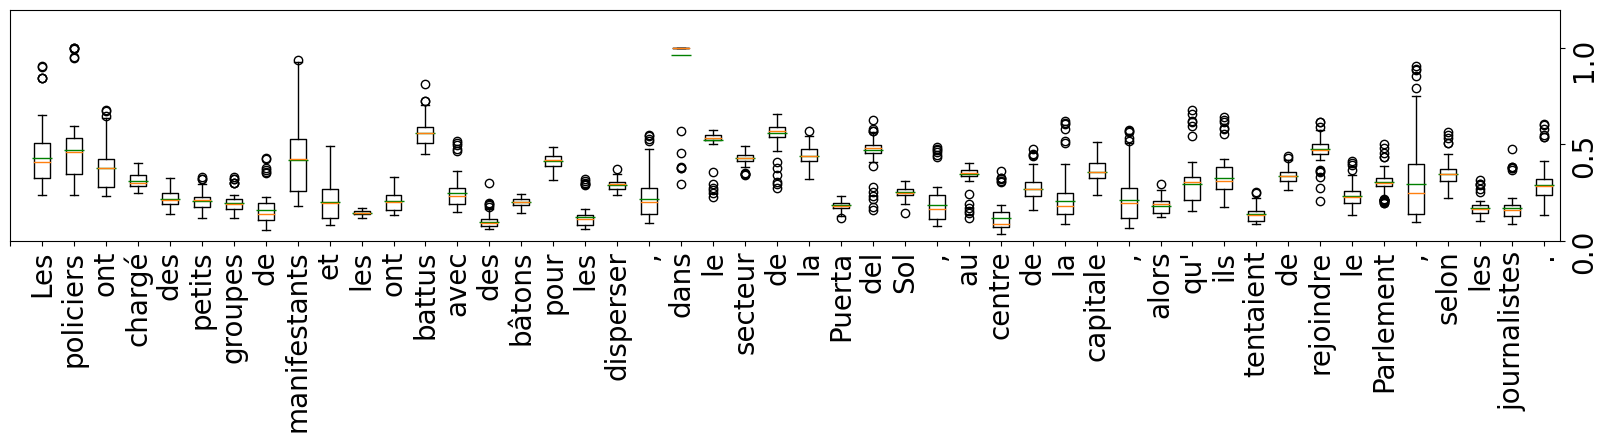

/DATA3/users/jebogaert/Documents/venvNb/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/DATA3/users/jebogaert/Documents/venvNb/lib/python3.10/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/DATA3/users/jebogaert/Documents/venvNb/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3723: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/DATA3/users/jebogaert/Documents/venvNb/lib/python3.10/site-packages/numpy/core/_methods.py:222: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/DATA3/users/jebogaert/Documents/venvNb/lib/python3.10/site-packages/numpy/core/_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.d

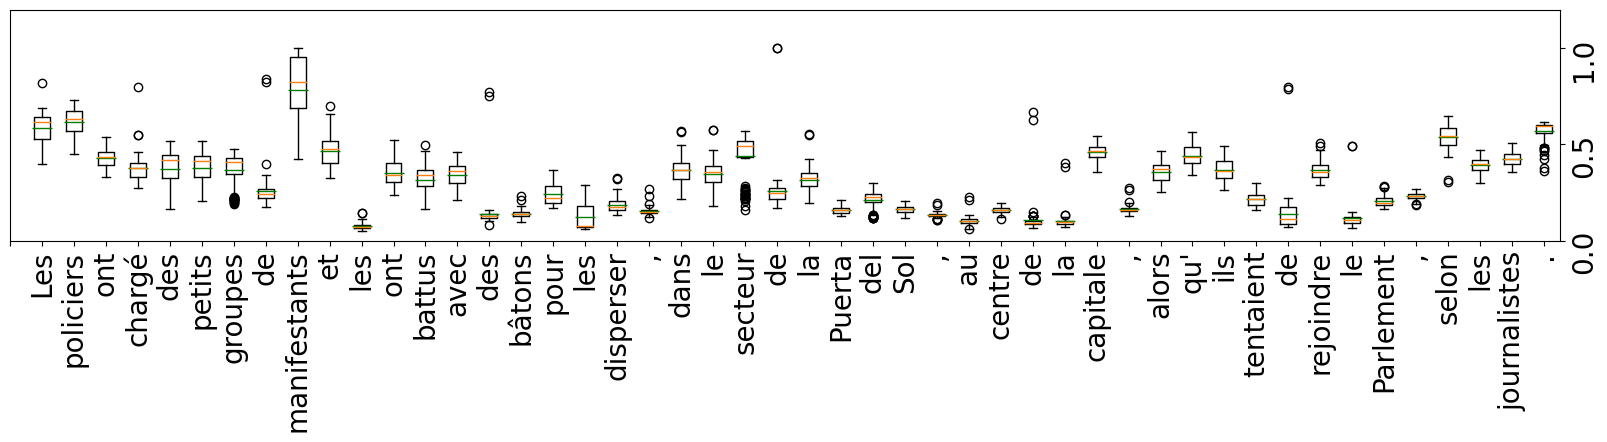

/DATA3/users/jebogaert/Documents/venvNb/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/DATA3/users/jebogaert/Documents/venvNb/lib/python3.10/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/DATA3/users/jebogaert/Documents/venvNb/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3723: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/DATA3/users/jebogaert/Documents/venvNb/lib/python3.10/site-packages/numpy/core/_methods.py:222: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/DATA3/users/jebogaert/Documents/venvNb/lib/python3.10/site-packages/numpy/core/_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.d

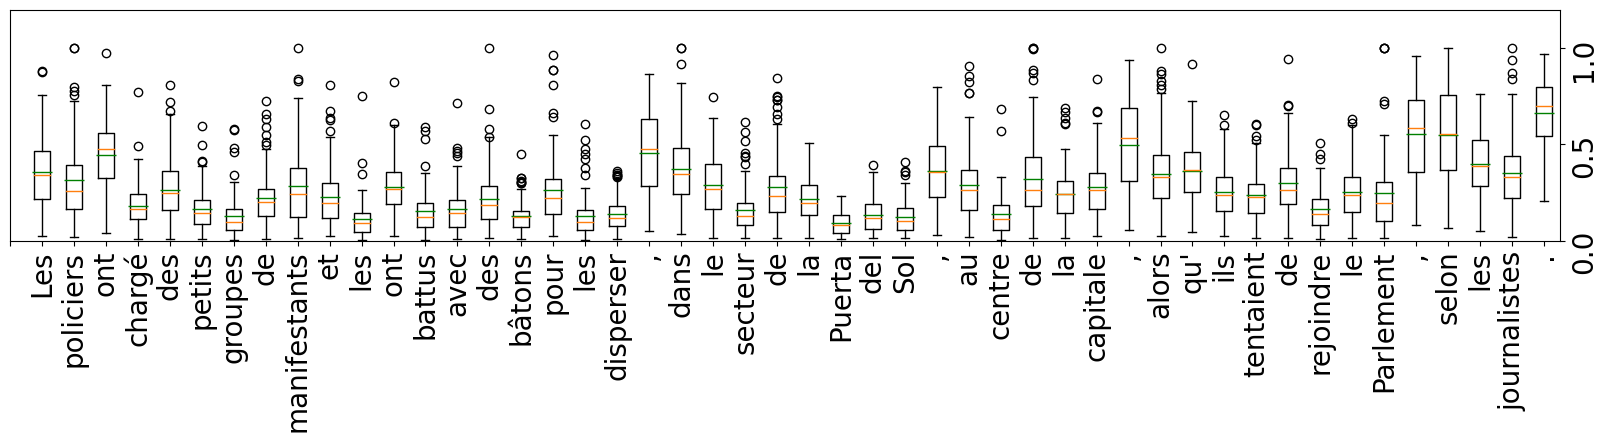

/DATA3/users/jebogaert/Documents/venvNb/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/DATA3/users/jebogaert/Documents/venvNb/lib/python3.10/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/DATA3/users/jebogaert/Documents/venvNb/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3723: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/DATA3/users/jebogaert/Documents/venvNb/lib/python3.10/site-packages/numpy/core/_methods.py:222: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/DATA3/users/jebogaert/Documents/venvNb/lib/python3.10/site-packages/numpy/core/_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.d

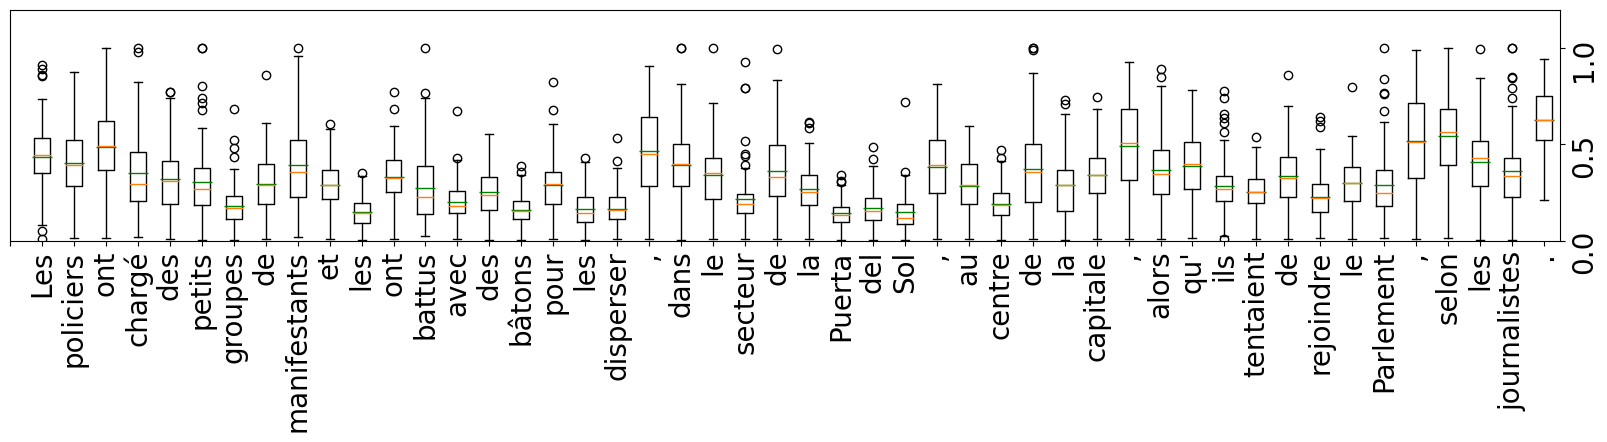

/DATA3/users/jebogaert/Documents/venvNb/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/DATA3/users/jebogaert/Documents/venvNb/lib/python3.10/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/DATA3/users/jebogaert/Documents/venvNb/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3723: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/DATA3/users/jebogaert/Documents/venvNb/lib/python3.10/site-packages/numpy/core/_methods.py:222: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/DATA3/users/jebogaert/Documents/venvNb/lib/python3.10/site-packages/numpy/core/_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.d

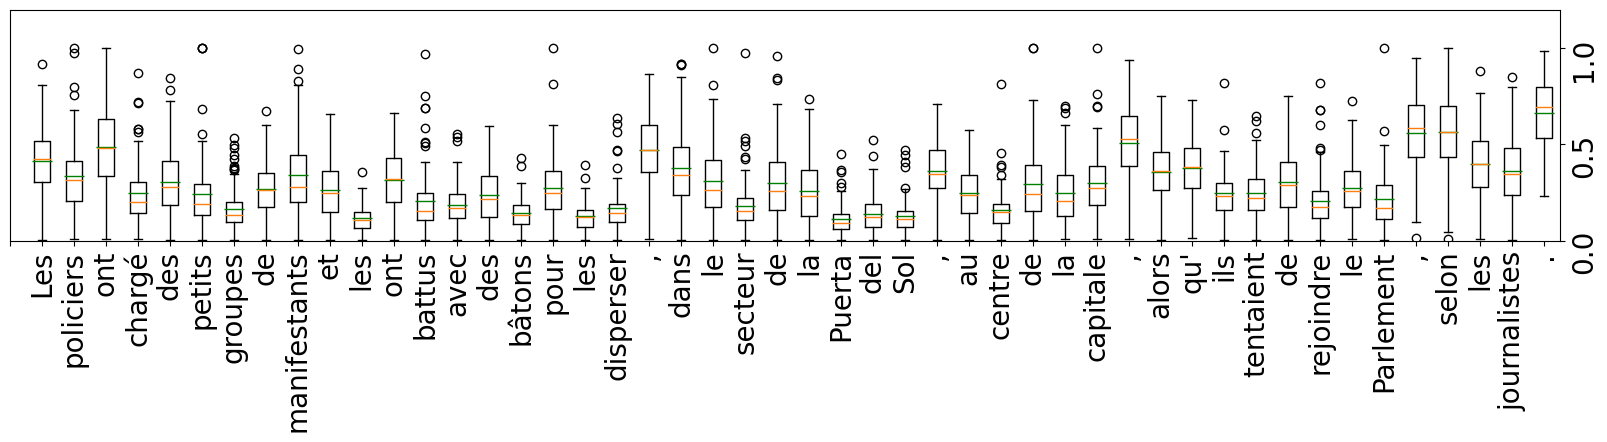

/DATA3/users/jebogaert/Documents/venvNb/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/DATA3/users/jebogaert/Documents/venvNb/lib/python3.10/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/DATA3/users/jebogaert/Documents/venvNb/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3723: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/DATA3/users/jebogaert/Documents/venvNb/lib/python3.10/site-packages/numpy/core/_methods.py:222: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/DATA3/users/jebogaert/Documents/venvNb/lib/python3.10/site-packages/numpy/core/_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.d

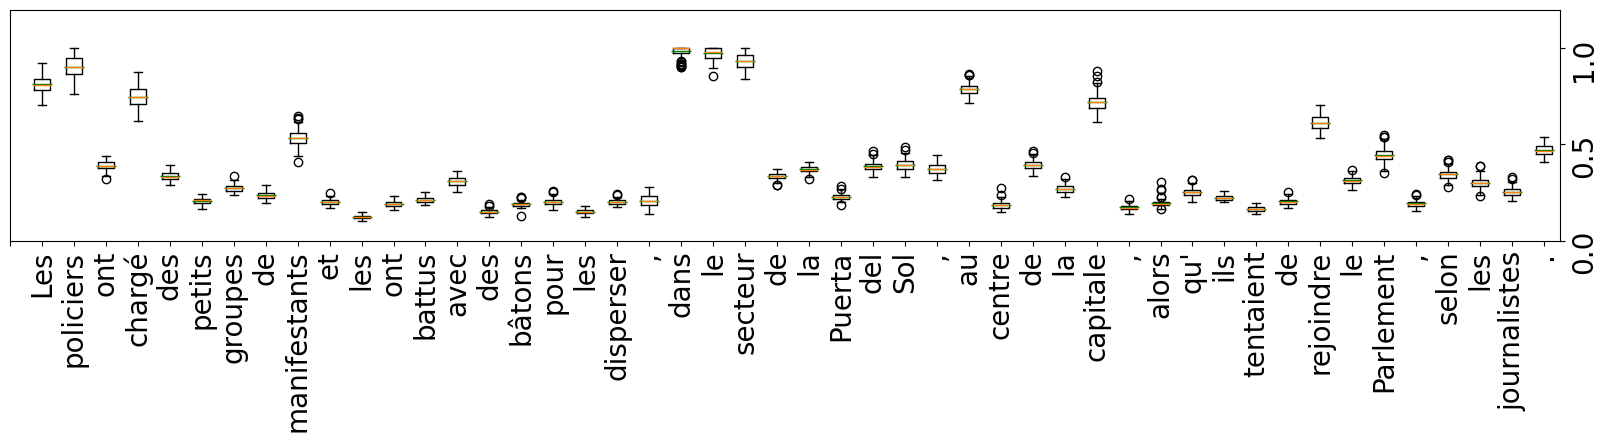

In [10]:
#Boxplots
selected_expls = {""}
selected_expls = equivalent_models_expls["fro_fp4"]["100_best"]
make_plot(selected_expls, text_nbr, withsnr = False, with_avg_val=True, nbr_of_seeds=100)

selected_expls = equivalent_models_expls["fro_nf4"]["100_best"]
make_plot(selected_expls, text_nbr, withsnr = False, with_avg_val=True, nbr_of_seeds=100)

selected_expls = equivalent_models_expls["ft_fp4"]["100_best"]
make_plot(selected_expls, text_nbr, withsnr = False, with_avg_val=True, nbr_of_seeds=100)

selected_expls = equivalent_models_expls["ft_nf4"]["100_best"]
make_plot(selected_expls, text_nbr, withsnr = False, with_avg_val=True, nbr_of_seeds=100)

selected_expls = equivalent_models_expls["ft"]["100_best"]
make_plot(selected_expls, text_nbr, withsnr = False, with_avg_val=True, nbr_of_seeds=100)

selected_expls = equivalent_models_expls["fro"]["100_best"]
make_plot(selected_expls, text_nbr, withsnr = False, with_avg_val=True, nbr_of_seeds=100)

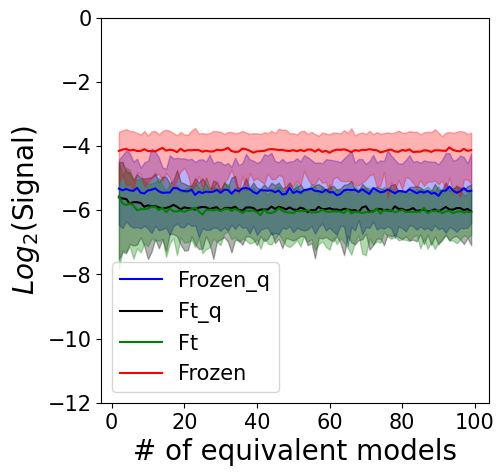

In [11]:
#Signal plot
expl_nbr = 100


plt.plot([i for i in range(2, expl_nbr)], [math.log2(i) for i in sig_fro], label = 'Frozen', color='red')
plt.fill_between([i for i in range(2, expl_nbr)], [math.log2(i) for i in lbs_fro], [math.log2(i) for i in hbs_fro], color = "red", alpha=0.3)

plt.plot([i for i in range(2, expl_nbr)], [math.log2(i) for i in sig_fro_fp4], label = 'Frozen_q', color='blue')
plt.fill_between([i for i in range(2, expl_nbr)], [math.log2(i) for i in lbs_fro_fp4], [math.log2(i) for i in hbs_fro_fp4], color = "blue", alpha=0.3)

#plt.plot([i for i in range(2, expl_nbr)], [math.log2(i) for i in sig_fro_nf4], label = 'fro_nf4')
#plt.fill_between([i for i in range(2, expl_nbr)], [math.log2(i) for i in lbs_fro_nf4], [math.log2(i) for i in hbs_fro_nf4], alpha=0.3)

plt.plot([i for i in range(2, expl_nbr)], [math.log2(i) for i in sig_ft], label = 'Ft', color='green')
plt.fill_between([i for i in range(2, expl_nbr)], [math.log2(i) for i in lbs_ft], [math.log2(i) for i in hbs_ft], color = "green", alpha=0.3)

plt.plot([i for i in range(2, expl_nbr)], [math.log2(i) for i in sig_ft_fp4], label = 'Ft_q', color='black')
plt.fill_between([i for i in range(2, expl_nbr)], [math.log2(i) for i in lbs_ft_fp4], [math.log2(i) for i in hbs_ft_fp4], color = "black", alpha=0.3)

#plt.plot([i for i in range(2, expl_nbr)], [math.log2(i) for i in sig_ft_nf4], label = 'ft_nf4')
#plt.fill_between([i for i in range(2, expl_nbr)], [math.log2(i) for i in lbs_ft_nf4], [math.log2(i) for i in hbs_ft_nf4], alpha=0.3)





plt.ylim(-12, 0)#For relm poster
plt.xlabel('# of equivalent models', fontsize=20)
plt.ylabel(r'$Log_{2}$(Signal)', fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.legend(fontsize=15)
plt.show()

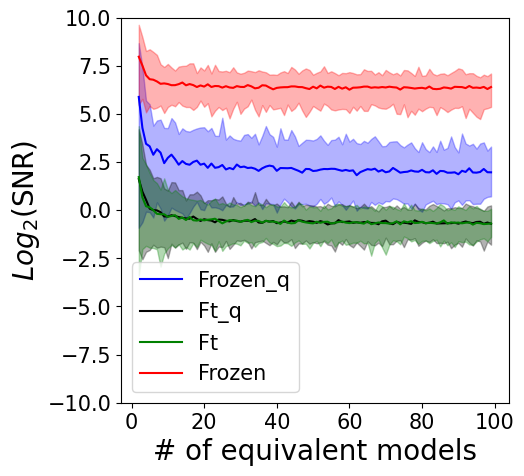

In [12]:
#SNR plot

plt.plot([i for i in range(2, expl_nbr)], [math.log2(i) for i in snr_fro], label = 'Frozen', color='red')
plt.fill_between([i for i in range(2, expl_nbr)], [math.log2(i) for i in lb_snr_fro], [math.log2(i) for i in hb_snr_fro], color = "red", alpha=0.3)

plt.plot([i for i in range(2, expl_nbr)], [math.log2(i) for i in snr_fro_fp4], label = 'Frozen_q', color='blue')
plt.fill_between([i for i in range(2, expl_nbr)], [math.log2(i) for i in lb_snr_fro_fp4], [math.log2(i) for i in hb_snr_fro_fp4], color = "blue", alpha=0.3)

#plt.plot([i for i in range(2, expl_nbr)], [math.log2(i) for i in sig_fro_nf4], label = 'fro_nf4')
#plt.fill_between([i for i in range(2, expl_nbr)], [math.log2(i) for i in lbs_fro_nf4], [math.log2(i) for i in hbs_fro_nf4], alpha=0.3)

plt.plot([i for i in range(2, expl_nbr)], [math.log2(i) for i in snr_ft], label = 'Ft', color='green')
plt.fill_between([i for i in range(2, expl_nbr)], [math.log2(i) for i in lb_snr_ft], [math.log2(i) for i in hb_snr_ft], color = "green", alpha=0.3)

plt.plot([i for i in range(2, expl_nbr)], [math.log2(i) for i in snr_ft_fp4], label = 'Ft_q', color='black')
plt.fill_between([i for i in range(2, expl_nbr)], [math.log2(i) for i in lb_snr_ft_fp4], [math.log2(i) for i in hb_snr_ft_fp4], color = "black", alpha=0.3)

#plt.plot([i for i in range(2, expl_nbr)], [math.log2(i) for i in sig_ft_nf4], label = 'ft_nf4')
#plt.fill_between([i for i in range(2, expl_nbr)], [math.log2(i) for i in lbs_ft_nf4], [math.log2(i) for i in hbs_ft_nf4], alpha=0.3)





plt.ylim(-10, 10)#For relm poster
plt.xlabel('# of equivalent models', fontsize=20)
plt.ylabel(r'$Log_{2}$(SNR)', fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.legend(fontsize=15)
plt.show()

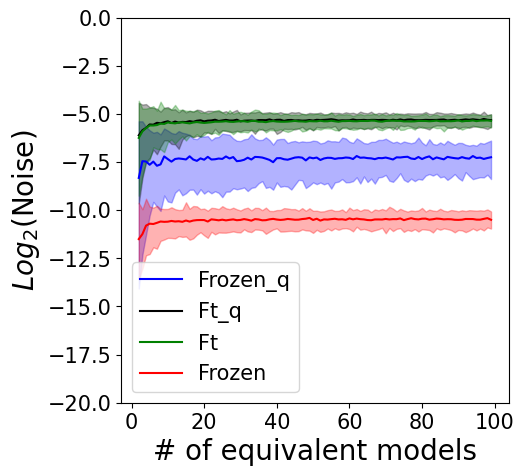

In [13]:
#Noise plot

plt.plot([i for i in range(2, expl_nbr)], [math.log2(i) for i in noise_fro], label = 'Frozen', color='red')
plt.fill_between([i for i in range(2, expl_nbr)], [math.log2(i) for i in lb_noise_fro], [math.log2(i) for i in hb_noise_fro], color = "red", alpha=0.3)

plt.plot([i for i in range(2, expl_nbr)], [math.log2(i) for i in noise_fro_fp4], label = 'Frozen_q', color='blue')
plt.fill_between([i for i in range(2, expl_nbr)], [math.log2(i) for i in lb_noise_fro_fp4], [math.log2(i) for i in hb_noise_fro_fp4], color = "blue", alpha=0.3)

#plt.plot([i for i in range(2, expl_nbr)], [math.log2(i) for i in sig_fro_nf4], label = 'fro_nf4')
#plt.fill_between([i for i in range(2, expl_nbr)], [math.log2(i) for i in lbs_fro_nf4], [math.log2(i) for i in hbs_fro_nf4], alpha=0.3)

plt.plot([i for i in range(2, expl_nbr)], [math.log2(i) for i in noise_ft], label = 'Ft', color='green')
plt.fill_between([i for i in range(2, expl_nbr)], [math.log2(i) for i in lb_noise_ft], [math.log2(i) for i in hb_noise_ft], color = "green", alpha=0.3)

plt.plot([i for i in range(2, expl_nbr)], [math.log2(i) for i in noise_ft_fp4], label = 'Ft_q', color='black')
plt.fill_between([i for i in range(2, expl_nbr)], [math.log2(i) for i in lb_noise_ft_fp4], [math.log2(i) for i in hb_noise_ft_fp4], color = "black", alpha=0.3)

#plt.plot([i for i in range(2, expl_nbr)], [math.log2(i) for i in sig_ft_nf4], label = 'ft_nf4')
#plt.fill_between([i for i in range(2, expl_nbr)], [math.log2(i) for i in lbs_ft_nf4], [math.log2(i) for i in hbs_ft_nf4], alpha=0.3)




plt.ylim(-20, 0)#For relm poster
plt.xlabel('# of equivalent models', fontsize=20)
plt.ylabel(r'$Log_{2}$(Noise)', fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.legend(fontsize=15)
plt.show()

In [14]:
import numpy as np 
import random 
import sys
from tqdm import tqdm
import matplotlib.pyplot as plt

def make_mix_plot(expls, pos, nbr_of_seeds = 200, markersize=22):
    
    values_by_word = {'ft': [], 'fro': [], 'ft_q': [], 'fro_q': []}
    mean_by_word = {'ft': [], 'fro': [], 'ft_q': [], 'fro_q': []}
    var_by_word = {'ft': [], 'fro': [], 'ft_q': [], 'fro_q': []}
    #values_by_word = {i: [[] for _ in expls[0][i]] for i in range(len(expls['ft']))}
    #words = {i: [i[1] for i in expls[0][i]] for i in range(len(expls['ft']))}
    words = [i[1] for i in expls['ft'][0][pos]]
    
    for model_type in expls:
        values_by_word[model_type] = [[] for i in expls[model_type][0][pos]] 
        
        for seed, seed_expl in enumerate(expls[model_type]):
            values = [i[0] for i in seed_expl[pos]] 
        
            for count, i in enumerate(values):
                values_by_word[model_type][count] += [i]
                
        mean_by_word[model_type] = [np.mean(i) for i in values_by_word[model_type]]
        var_by_word[model_type] = [np.var(i) for i in values_by_word[model_type]]
        assert len(words) == len(mean_by_word[model_type]) == len(var_by_word[model_type]) == len(values_by_word[model_type])
    
    
    plt.rcParams["figure.figsize"] = (20,6)

    ax1 = plt.subplot(4,1,4)
    x = [i+1 for i in range(len(words))]
    ax1.boxplot(values_by_word['ft'], positions = x, bootstrap=1000)
    
    ax1.plot(x, mean_by_word['ft'], 'g_', markersize=markersize)
    
    ax1.set_ylabel("Ft", fontsize=20)
    plt.gca().yaxis.tick_right()
    plt.yticks([0, 0.5, 1], fontsize=12, rotation=90)
    plt.ylim(0, 1.1)
    

    ax2 = plt.subplot(4,1,3)
    
    ax2.boxplot(values_by_word['ft_q'], positions = x, bootstrap=1000)
    ax2.plot(x, mean_by_word['ft_q'], 'g_', markersize=markersize)
    
    ax2.set_ylabel("Ft_q", fontsize=20)
    ax2.tick_params(
        axis='x',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom=False,      # ticks along the bottom edge are off
        top=False,         # ticks along the top edge are off
        labelbottom=False) # labels along the bottom edge are off
    plt.gca().yaxis.tick_right()
    plt.yticks([0, 0.5, 1], fontsize=12, rotation=90)
    plt.ylim(0, 1.1)
    
    
    ax3 = plt.subplot(4,1,2)
    
    ax3.boxplot(values_by_word['fro'], positions = x, bootstrap=1000)
    ax3.plot(x, mean_by_word['fro'], 'g_', markersize=markersize)
    
    ax3.set_ylabel("Fro", fontsize=20)
    ax3.tick_params(
        axis='x',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom=False,      # ticks along the bottom edge are off
        top=False,         # ticks along the top edge are off
        labelbottom=False) # labels along the bottom edge are off
    plt.gca().yaxis.tick_right()
    plt.yticks([0, 0.5, 1], fontsize=12, rotation=90)
    plt.ylim(0, 1.1)
    
    
    ax4 = plt.subplot(4,1,1)
    
    ax4.boxplot(values_by_word['fro_q'], positions = x, bootstrap=1000)
    ax4.plot(x, mean_by_word['fro_q'], 'g_', markersize=markersize)
    
    ax4.set_ylabel("Fro_q", fontsize=20)
    ax4.tick_params(
        axis='x',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom=False,      # ticks along the bottom edge are off
        top=False,         # ticks along the top edge are off
        labelbottom=False) # labels along the bottom edge are off
    plt.gca().yaxis.tick_right()
    plt.yticks([0, 0.5, 1], fontsize=12, rotation=90)
    plt.ylim(0, 1.1)
    
    
    ax1.set_xticks(x, words, fontsize=20, rotation=90)
    plt.gca().yaxis.tick_right()
    plt.show()

    plt.rcParams["figure.figsize"] = (5,5)